# SDPA Final Coursework
# PART 2 - Data Analysis

I will use some data comes from the NBA website to do the analysis. The NBA website provides a lot of data about the NBA, including the game data, the player data, the team data, etc.

I will use three datasets for the analysis:
- `games_df`: The statistics of every game in the 2022-23 season.
- `teams_df`: The estimated metrics for every team in the 2022-23 season.
- `players_df`: The statistics of every player who plays in the 2022-23 season.

# STEP 1 - Crawl a dataset
In this step, I will use the NBA API to crawl a dataset of NBA games and players. 
Use the following command to install the NBA API:
`pip install nba_api`

I will collect the data of the 2022-23 NBA season, which should be my core dataset for the analysis.


In [5]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr

In [6]:
# collect data for every game in the 2022-23 season
from nba_api.stats.endpoints import leaguegamefinder

gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2022-23')

# use get_data_frames() to get the dataframe of the games data
games_df = gamefinder.get_data_frames()[0]

# save the dataframe to a csv file
# games_df.to_csv('games_df.csv', index=False)

games_df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42022,1610612748,MIA,Miami Heat,0042200405,2023-06-12,MIA @ DEN,L,240,89,33,96,0.344,9,35,0.257,14,16,0.875,11,33,44,18,9,7,8,21,-5.0
1,42022,1610612743,DEN,Denver Nuggets,0042200405,2023-06-12,DEN vs. MIA,W,240,94,38,84,0.452,5,28,0.179,13,23,0.565,11,46,57,21,6,7,14,13,5.0
2,42022,1610612743,DEN,Denver Nuggets,0042200404,2023-06-09,DEN @ MIA,W,242,108,39,79,0.494,14,28,0.500,16,21,0.762,5,29,34,26,11,7,6,18,13.0
3,42022,1610612748,MIA,Miami Heat,0042200404,2023-06-09,MIA vs. DEN,L,240,95,35,78,0.449,8,25,0.320,17,20,0.850,8,29,37,23,2,3,14,19,-13.0
4,42022,1610612743,DEN,Denver Nuggets,0042200403,2023-06-07,DEN @ MIA,W,238,109,41,80,0.513,5,18,0.278,22,27,0.815,13,45,58,28,3,5,13,18,15.0


In [7]:
# collect the estimated metrics for every team in the 2022-23 season
from nba_api.stats.endpoints import TeamEstimatedMetrics

# get the team estimated metrics
team_estimated_metrics = TeamEstimatedMetrics(season='2022-23',)

# get the dataframe
teams_df = team_estimated_metrics.get_data_frames()[0]

# Selecting the specified columns from the dataset
teams_df=teams_df[['TEAM_NAME',"GP", "W", "L", "W_PCT", "E_OFF_RATING", "E_DEF_RATING", "E_PACE"]]

# save the dataframe to a csv file
# teams_df.to_csv('teams_df.csv', index=False)

teams_df.head()

,TEAM_NAME,GP,W,L,W_PCT,E_OFF_RATING,E_DEF_RATING,E_PACE
0,Golden State Warriors,82,44,38,0.537,113.5,111.4,104.2
1,San Antonio Spurs,82,22,60,0.268,107.2,117.7,104.1
2,Indiana Pacers,82,35,47,0.427,111.0,115.4,103.8
3,Memphis Grizzlies,82,51,31,0.622,112.3,108.3,103.7
4,Oklahoma City Thunder,82,40,42,0.488,112.3,111.4,103.6


In [56]:
# collect players' data for each teams in the 2022-23 season
from nba_api.stats.static import teams
from nba_api.stats.endpoints import teamplayerdashboard


# get all the teams
nba_teams = teams.get_teams()

# set the playoffs teams--eastern conference and western conference
# eastern_teams = ['Milwaukee Bucks', 'Miami Heat', 'Boston Celtics', 'Philadelphia 76ers', 
#                  'Cleveland Cavaliers', 'New York Knicks', 'Brooklyn Nets', 'Atlanta Hawks']
# western_teams = ['Los Angeles Lakers', 'Golden State Warriors', 'Denver Nuggets', 
#                  'Los Angeles Clippers', 'Phoenix Suns', 'Sacramento Kings', 
#                  'Minnesota Timberwolves', 'Memphis Grizzlies']

# Eastern Conference
eastern_teams = [
    "Boston Celtics", "Brooklyn Nets", "New York Knicks", "Philadelphia 76ers", "Toronto Raptors",
    "Chicago Bulls", "Cleveland Cavaliers", "Detroit Pistons", "Indiana Pacers", "Milwaukee Bucks",
    "Atlanta Hawks", "Charlotte Hornets", "Miami Heat", "Orlando Magic", "Washington Wizards"
]

# Western Conference
western_teams = [
    "Golden State Warriors", "LA Clippers", "Los Angeles Lakers", "Phoenix Suns", "Sacramento Kings",
    "Dallas Mavericks", "Houston Rockets", "Memphis Grizzlies", "New Orleans Pelicans", "San Antonio Spurs",
    "Denver Nuggets", "Minnesota Timberwolves", "Oklahoma City Thunder", "Portland Trail Blazers", "Utah Jazz"
]

selected_teams = [team for team in nba_teams if team['full_name'] in eastern_teams + western_teams]

selected_teams_player_data = []

for team in selected_teams:
    team_id = team['id']
    team_name = team['full_name']

    conference = 'Eastern' if team_name in eastern_teams else 'Western'

    # create a TeamPlayerDashboard instance, and set the season to 2022-23
    team_dashboard = teamplayerdashboard.TeamPlayerDashboard(team_id=team_id, season='2022-23')

    # get the dataframe, players data is in the second dataframe
    player_stats = team_dashboard.get_data_frames()[1]
    player_stats['Team'] = team_name
    player_stats['Conference'] = conference
    selected_teams_player_data.append(player_stats)

# concat the dataframes
combined_player_data = pd.concat(selected_teams_player_data, ignore_index=True)

# choose the columns
players_df = combined_player_data[['PLAYER_NAME', 'Team', 'Conference', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'PTS', 'AST', 'STL', 'BLK', 'REB', 'OREB', 'DREB', 'TOV', 'PF', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'FG_PCT', 'FG3_PCT', 'FT_PCT']]

# save the dataframe to a csv file
players_df.to_csv('players_df.csv', index=False)

players_df.head(5)

,PLAYER_NAME,Team,Conference,GP,W,L,W_PCT,MIN,PTS,AST,STL,BLK,REB,OREB,DREB,TOV,PF,FGM,FGA,FG3M,FG3A,FTM,FTA,FG_PCT,FG3_PCT,FT_PCT
0,AJ Griffin,Atlanta Hawks,Eastern,72,34,38,0.472,1401.435000,639,73,42,12,153,37,116,42,87,248,533,101,259,42,47,0.465,0.390,0.894
1,Aaron Holiday,Atlanta Hawks,Eastern,63,32,31,0.508,845.256667,247,89,37,12,74,25,49,36,79,92,220,36,88,27,32,0.418,0.409,0.844
2,Bogdan Bogdanovic,Atlanta Hawks,Eastern,54,27,27,0.500,1508.608333,756,150,43,18,165,23,142,65,86,273,611,146,360,64,77,0.447,0.406,0.831
3,Bruno Fernando,Atlanta Hawks,Eastern,8,4,4,0.500,41.333333,27,1,0,3,15,6,9,5,6,11,19,0,3,5,6,0.579,0.000,0.833
4,Clint Capela,Atlanta Hawks,Eastern,65,35,30,0.538,1730.083333,779,58,45,79,717,258,459,54,139,350,536,0,1,79,131,0.653,0.000,0.603


1. Where does the data come from?
- The data comes from the NBA website. The NBA website provides a lot of data about the NBA, including the game data, the player data, the team data, etc.

2. What are the variables of interest?
- For the `games_df`, we are interested in the statistics of the game, such as the points, rebounds, assists, steals, blocks, turnovers, personal fouls, etc. 
- For the `teams`, we are interested in the estimated metrics of the team, such as the offensive rating, defensive rating, pace, etc.
- For the `players_df`, we are interested in the statistics of the player, such as the points, rebounds, assists, steals, blocks, turnovers, personal fouls, etc. There are 588 players in the dataset.

3. How was the data collected?
- The data was collected by using the NBA API. The NBA API is a service that provides endpoints for collecting data from the NBA. It is a free service provided by the NBA.

# STEP 2 - Data Cleaning
In this step, I will clean the data and prepare it for analysis. It includes:
- Handling missing values
- Handling outliers
- Transforming data types
- Enriching the dataset

The "teams_df" and "player_df" dataframe are already clean, so I will only clean the "games_df" dataframe.

### 2.1 Data Overview
There are 28 columns in the `games_df` dataframe, and 4322 rows.
- SEASON_ID: Identifier for the season.
- TEAM_ID: Unique identifier for a team.
- TEAM_ABBREVIATION: Abbreviation of the team's name.
- TEAM_NAME: Full name of the team.
- GAME_ID: Unique identifier for a game.
- GAME_DATE: Date of the game.
- MATCHUP: Details of the game matchup, often shown as "Home Team @ Away Team" or "Home Team vs. Away Team."
- WL: Game outcome, Win (W) or Loss (L).
- MIN: Total minutes played by the team in the game.
- PTS: Total points scored by the team.
- FGM: Field goals made.
- FGA: Field goals attempted.
- FG_PCT: Field goal percentage.
- FG3M: Three-point field goals made.
- FG3A: Three-point field goals attempted.
- FG3_PCT: Three-point field goal percentage.
- FTM: Free throws made.
- FTA: Free throws attempted.
- FT_PCT: Free throw percentage.
- OREB: Offensive rebounds.
- DREB: Defensive rebounds.
- REB: Total rebounds.
- AST: Assists.
- STL: Steals.
- BLK: Blocks.
- TOV: Turnovers.
- PF: Personal fouls.
- PLUS_MINUS: Point differential.

There are 8 columns in the `teams_df` dataframe, and 30 rows (30 teams).
- TEAM_NAME: Full name of the team.
- GP: Games played.
- W: Wins.
- L: Losses.
- W_PCT: Win percentage.
- E_OFF_RATING: Offensive rating.
- E_DEF_RATING: Defensive rating.
- E_PACE: The number of offensive possessions per 48 minutes.

There are 26 columns in the `players_df` dataframe, and 589 rows for 589 players.
- PLAYER_NAME: Player's name.
- Team: The team that the player belongs to.
- Conference: The conference that the team belongs to.
- GP: Games played.
- W: Wins.
- L: Losses.
- W_PCT: Win percentage.
- MIN: Minutes played.
- PTS: Points.
- AST: Assists.
- STL: Steals.
- BLK: Blocks.
- REB: Total rebounds.
- OREB: Offensive rebounds.
- DREB: Defensive rebounds.
- TOV: Turnovers.
- PF: Personal fouls.
- FGM: Field goals made.
- FGA: Field goals attempted.
- FG3M: Three-point field goals made.
- FG3A: Three-point field goals attempted.
- FTM: Free throws made.
- FTA: Free throws attempted.
- FG_PCT: Field goal percentage.
- FG3_PCT: Three-point field goal percentage.
- FT_PCT: Free throw percentage.


In [9]:
# read the csv file
games_df=pd.read_csv('games_df.csv')

games_df
# (4322, 28)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42022,1610612748,MIA,Miami Heat,42200405,2023-06-12,MIA @ DEN,L,240,89,33,96,0.344,9,35,0.257,14,16,0.875,11,33,44,18,9,7,8,21,-5.0
1,42022,1610612743,DEN,Denver Nuggets,42200405,2023-06-12,DEN vs. MIA,W,240,94,38,84,0.452,5,28,0.179,13,23,0.565,11,46,57,21,6,7,14,13,5.0
2,42022,1610612748,MIA,Miami Heat,42200404,2023-06-09,MIA vs. DEN,L,240,95,35,78,0.449,8,25,0.320,17,20,0.850,8,29,37,23,2,3,14,19,-13.0
3,42022,1610612743,DEN,Denver Nuggets,42200404,2023-06-09,DEN @ MIA,W,242,108,39,79,0.494,14,28,0.500,16,21,0.762,5,29,34,26,11,7,6,18,13.0
4,42022,1610612743,DEN,Denver Nuggets,42200403,2023-06-07,DEN @ MIA,W,238,109,41,80,0.513,5,18,0.278,22,27,0.815,13,45,58,28,3,5,13,18,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,12022,1610612749,MIL,Milwaukee Bucks,12200003,2022-10-01,MIL vs. MEM,L,240,102,37,86,0.430,13,37,0.351,15,21,0.714,17,33,50,22,10,3,23,29,-5.0
4318,12022,1610612746,LAC,LA Clippers,12200002,2022-09-30,LAC vs. MRA,W,242,121,39,77,0.506,13,29,0.448,30,43,0.698,15,40,55,27,9,6,23,23,44.2
4319,12022,1610612744,GSW,Golden State Warriors,12200001,2022-09-30,GSW @ WAS,W,239,96,29,79,0.367,7,26,0.269,31,40,0.775,10,52,62,18,6,3,17,27,9.0
4320,12022,1610612764,WAS,Washington Wizards,12200001,2022-09-30,WAS vs. GSW,L,240,87,31,84,0.369,6,35,0.171,19,30,0.633,7,37,44,20,12,10,14,27,-9.0


I found that there are some teams that not belong to the NBA, such as "Long Island Nets", "Rio Grande Valley Vipers", etc. So I will only keep the teams that belong to the NBA.

In [10]:
games_df['TEAM_NAME'].unique()

array(['Miami Heat', 'Denver Nuggets', 'Boston Celtics',
       'Los Angeles Lakers', 'Philadelphia 76ers',
       'Golden State Warriors', 'New York Knicks', 'Phoenix Suns',
       'Sacramento Kings', 'Memphis Grizzlies', 'Atlanta Hawks',
       'Cleveland Cavaliers', 'Milwaukee Bucks', 'LA Clippers',
       'Minnesota Timberwolves', 'Brooklyn Nets', 'Oklahoma City Thunder',
       'Chicago Bulls', 'Toronto Raptors', 'New Orleans Pelicans',
       'Detroit Pistons', 'Charlotte Hornets', 'Orlando Magic',
       'Washington Wizards', 'Utah Jazz', 'Portland Trail Blazers',
       'Houston Rockets', 'Dallas Mavericks', 'Indiana Pacers',
       'San Antonio Spurs', 'Delaware Blue Coats',
       'Rio Grande Valley Vipers', 'Long Island Nets',
       'Sioux Falls Skyforce', 'Memphis Hustle', 'Cleveland Charge',
       'Stockton Kings', 'Capital City Go-Go', 'Maine Celtics',
       'South Bay Lakers', 'Salt Lake City Stars', 'Fort Wayne Mad Ants',
       'G League Ignite', 'Greensboro Swarm',

In [11]:
# NBA teams LIST
nba_teams = [
    "Boston Celtics", "Brooklyn Nets", "New York Knicks", "Philadelphia 76ers", "Toronto Raptors",
    "Chicago Bulls", "Cleveland Cavaliers", "Detroit Pistons", "Indiana Pacers", "Milwaukee Bucks",
    "Atlanta Hawks", "Charlotte Hornets", "Miami Heat", "Orlando Magic", "Washington Wizards",
    "Denver Nuggets", "Minnesota Timberwolves", "Oklahoma City Thunder", "Portland Trail Blazers", "Utah Jazz",
    "Golden State Warriors", "LA Clippers", "Los Angeles Lakers", "Phoenix Suns", "Sacramento Kings",
    "Dallas Mavericks", "Houston Rockets", "Memphis Grizzlies", "New Orleans Pelicans", "San Antonio Spurs"
]

# filter the games dataframe
games_nba = games_df[games_df['TEAM_NAME'].isin(nba_teams)].copy()
games_nba['TEAM_NAME'].unique()
# check the shape of the dataframe
# games_nba.shape # (2775, 28)

array(['Miami Heat', 'Denver Nuggets', 'Boston Celtics',
       'Los Angeles Lakers', 'Philadelphia 76ers',
       'Golden State Warriors', 'New York Knicks', 'Phoenix Suns',
       'Sacramento Kings', 'Memphis Grizzlies', 'Atlanta Hawks',
       'Cleveland Cavaliers', 'Milwaukee Bucks', 'LA Clippers',
       'Minnesota Timberwolves', 'Brooklyn Nets', 'Oklahoma City Thunder',
       'Chicago Bulls', 'Toronto Raptors', 'New Orleans Pelicans',
       'Detroit Pistons', 'Charlotte Hornets', 'Orlando Magic',
       'Washington Wizards', 'Utah Jazz', 'Portland Trail Blazers',
       'Houston Rockets', 'Dallas Mavericks', 'Indiana Pacers',
       'San Antonio Spurs'], dtype=object)

There are 30 teams in the NBA, and the dataset includes games for both home teams and away teams. 

`Teams_A vs Teams_B` means that Team A is the home team, and Team B is the away team.
`Teams_A @ Teams_B` means that Team A is the away team, and Team B is the home team.

It is not convenient for the analysis, so later I will try to merge the rows of one game into one row.

### 2.2 Handling Missing Values
Fortunately, there are no missing values in the `games_nba` dataframe.

In [12]:
# check the missing values
games_nba.isnull().sum() 

SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
GAME_ID              0
GAME_DATE            0
MATCHUP              0
WL                   0
MIN                  0
PTS                  0
FGM                  0
FGA                  0
FG_PCT               0
FG3M                 0
FG3A                 0
FG3_PCT              0
FTM                  0
FTA                  0
FT_PCT               0
OREB                 0
DREB                 0
REB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
PLUS_MINUS           0
dtype: int64

### 2.3 Handling Outliers
First, I will check the outliers of the `PTS`(points),`REB`(rebounds),`AST`(assists),`STL`(steals),`BLK`(blocks),`TOV`(turnovers),`PF`(personal fouls) columns.

In [13]:
# choose the columns
stats_columns = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

# print the summary statistics
games_nba[stats_columns].describe()


,PTS,REB,AST,STL,BLK,TOV,PF
count,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000
mean,114.141261,43.575135,25.178018,7.343063,4.700901,13.513874,20.105946
std,12.112079,6.806579,4.892649,2.917479,2.459312,3.965843,4.146769
min,75.000000,23.000000,12.000000,0.000000,0.000000,1.000000,8.000000
25%,106.000000,39.000000,22.000000,5.000000,3.000000,11.000000,17.000000
50%,114.000000,43.000000,25.000000,7.000000,4.000000,13.000000,20.000000
75%,122.000000,48.000000,28.000000,9.000000,6.000000,16.000000,23.000000
max,176.000000,73.000000,47.000000,20.000000,19.000000,27.000000,35.000000


In the summary statistics, we can see that the minimum value of the `PTS` column is 20, and the maximum value of the `TOV` column is 33, which are not reasonable. 

Use the boxplot to check the outliers.


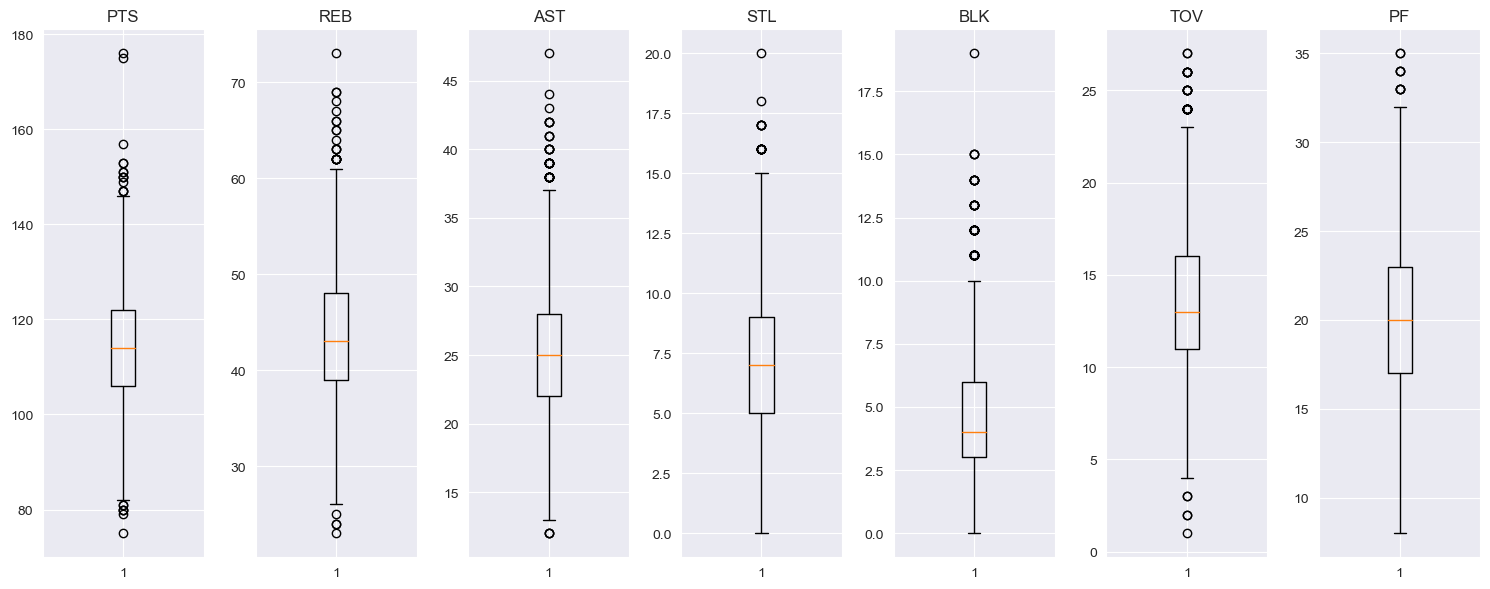

In [14]:
plt.figure(figsize=(15, 6))
for i, col in enumerate(stats_columns):
    plt.subplot(1, len(stats_columns), i + 1)
    plt.boxplot(games_nba[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### Dealing with the outliers by using the IQR method
- lower bound = Q1 - 1.5 * IQR
- upper bound = Q3 + 1.5 * IQR
- IQR = Q3 - Q1

For `PTS` column, it is possible the final score of the game more than 180 or less than 80, so I will not deal with the outliers in this column.

For the rest of the columns, I will replace the outliers with the median value, which should be more reasonable.

In [15]:
# calculate the lower bound and upper bound
for col in ['REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']:
    Q1 = games_nba[col].quantile(0.25)
    Q3 = games_nba[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median = games_nba[col].median()
    games_nba.loc[(games_nba[col] < lower_bound) | (games_nba[col] > upper_bound), col] = median


games_nba[stats_columns].describe()


,PTS,REB,AST,STL,BLK,TOV,PF
count,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000
mean,114.141261,43.445766,25.000000,7.280721,4.527928,13.401802,20.061261
std,12.112079,6.516343,4.570524,2.818617,2.186805,3.749597,4.072504
min,75.000000,26.000000,13.000000,0.000000,0.000000,4.000000,8.000000
25%,106.000000,39.000000,22.000000,5.000000,3.000000,11.000000,17.000000
50%,114.000000,43.000000,25.000000,7.000000,4.000000,13.000000,20.000000
75%,122.000000,48.000000,28.000000,9.000000,6.000000,16.000000,23.000000
max,176.000000,61.000000,37.000000,15.000000,10.000000,23.000000,32.000000


### 2.5 Enriching the Dataset
#### 1. Parsing Dates
I found that the `GAME_DATE` column is stored as a string, so I will parse it to the datetime type.

Then we can use the date column to do the time series analysis.

In [16]:
type(games_nba['GAME_DATE'][0])

str

In [17]:
# parse the GAME_DATE column to the datetime type
games_nba['GAME_DATE'] = pd.to_datetime(games_nba['GAME_DATE'])
# games_nba.to_csv('games_nba.csv', index=False)

#### 2. Combining the rows of one game
Try to merge two rows for one game into one row. Use the `combine_team_games` function from the [nba_api/docs/examples](https://github.com/swar/nba_api/blob/master/docs/examples/Finding%20Games.ipynb)

This function will combine the two rows of one game into one row, and the home team will be TEAM_A, the away team will be TEAM_B.

The rest of the columns are the statistics of the game, which will be columns that represent the statistics of the home team and the away team respectively.

After that, we can easily get the data from the home team and the away team in one row.

In [18]:
def combine_team_games(df):
    # Inner Join every row to all others with the same game ID.
    # suffixes are appended to overlapping column names.
    # Team_A is home team, Team_B is away team.
    joined = pd.merge(df, df, suffixes=['_A', '_B'],
                      on=['SEASON_ID', 'GAME_ID', 'GAME_DATE'])
    
    # Filter out any row that is joined to itself.
    result = joined[joined.TEAM_ID_A != joined.TEAM_ID_B]
    
    result = result[result.MATCHUP_A.str.contains(' vs. ')]

    return result
    
# Combine the game rows into one. By default, the home team will be TEAM_A.
games_merged = combine_team_games(games_nba)
games_merged.head() # (1295,53)

,SEASON_ID,TEAM_ID_A,TEAM_ABBREVIATION_A,TEAM_NAME_A,GAME_ID,GAME_DATE,MATCHUP_A,WL_A,MIN_A,PTS_A,FGM_A,FGA_A,FG_PCT_A,FG3M_A,FG3A_A,FG3_PCT_A,FTM_A,FTA_A,FT_PCT_A,OREB_A,DREB_A,REB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,PLUS_MINUS_A,TEAM_ID_B,TEAM_ABBREVIATION_B,TEAM_NAME_B,MATCHUP_B,WL_B,MIN_B,PTS_B,FGM_B,FGA_B,FG_PCT_B,FG3M_B,FG3A_B,FG3_PCT_B,FTM_B,FTA_B,FT_PCT_B,OREB_B,DREB_B,REB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PLUS_MINUS_B
2,42022,1610612743,DEN,Denver Nuggets,42200405,2023-06-12,DEN vs. MIA,W,240,94,38,84,0.452,5,28,0.179,13,23,0.565,11,46,57,21,6,7,14,13,5.0,1610612748,MIA,Miami Heat,MIA @ DEN,L,240,89,33,96,0.344,9,35,0.257,14,16,0.875,11,33,44,18,9,7,8,21,-5.0
5,42022,1610612748,MIA,Miami Heat,42200404,2023-06-09,MIA vs. DEN,L,240,95,35,78,0.449,8,25,0.320,17,20,0.850,8,29,37,23,2,3,14,19,-13.0,1610612743,DEN,Denver Nuggets,DEN @ MIA,W,242,108,39,79,0.494,14,28,0.500,16,21,0.762,5,29,34,26,11,7,6,18,13.0
10,42022,1610612748,MIA,Miami Heat,42200403,2023-06-07,MIA vs. DEN,L,240,94,34,92,0.370,11,35,0.314,15,19,0.789,10,23,33,20,7,3,4,22,-15.0,1610612743,DEN,Denver Nuggets,DEN @ MIA,W,238,109,41,80,0.513,5,18,0.278,22,27,0.815,13,45,58,28,3,5,13,18,15.0
13,42022,1610612743,DEN,Denver Nuggets,42200402,2023-06-04,DEN vs. MIA,L,239,108,39,75,0.520,11,28,0.393,19,22,0.864,9,29,38,23,7,2,13,21,-3.0,1610612748,MIA,Miami Heat,MIA @ DEN,W,239,111,38,78,0.487,17,35,0.486,18,20,0.900,8,23,31,28,5,4,11,22,3.0
17,42022,1610612743,DEN,Denver Nuggets,42200401,2023-06-01,DEN vs. MIA,W,239,104,40,79,0.506,8,27,0.296,16,20,0.800,6,39,45,29,4,4,10,8,11.0,1610612748,MIA,Miami Heat,MIA @ DEN,L,241,93,39,96,0.406,13,39,0.333,2,2,1.000,11,32,43,26,5,4,8,15,-11.0


#### 3. Creating new features
Next step, create some new features which should be useful for the analysis.

First, focus on the "games_merged" dataframe.

In [19]:
# `PTS_DIFF` is the difference of the scores of the home team and the away team
games_merged['PTS_DIFF'] = games_merged['PTS_A'] - games_merged['PTS_B']

# `SCORING_EFF_A/B` is the scoring efficiency of the home team/away team
# scoring efficiency = points / (field goals attempts + 3-point field goals attempts)
games_merged['SCORING_EFF_A'] = games_merged['PTS_A'] / (games_merged['FGA_A'] + games_merged['FG3A_A'])
games_merged['SCORING_EFF_B'] = games_merged['PTS_B'] / (games_merged['FGA_B'] + games_merged['FG3A_B'])

# `AST_TOV_RATIO_A/B` is the assist-turnover ratio of the home team/away team
games_merged['AST_TOV_RATIO_A'] = games_merged['AST_A'] / games_merged['TOV_A']
games_merged['AST_TOV_RATIO_B'] = games_merged['AST_B'] / games_merged['TOV_B']

# `THREE_PT_EFF_A/B` is the three-point efficiency of the home team/away team
games_merged['THREE_PT_EFF_A'] = games_merged['FG3M_A'] / games_merged['FG3A_A']
games_merged['THREE_PT_EFF_B'] = games_merged['FG3M_B'] / games_merged['FG3A_B']

# Handle the potential division by zero
games_merged.replace([float('inf'), float('-inf')], 0, inplace=True)
games_merged.fillna(0, inplace=True)

In [20]:
# check the new features
games_merged[['MATCHUP_A','WL_A','PTS_DIFF', 'SCORING_EFF_A', 'SCORING_EFF_B', 'AST_TOV_RATIO_A', 'AST_TOV_RATIO_B', 'THREE_PT_EFF_A', 'THREE_PT_EFF_B']].head()

# games_merged.head()
# games_merged.to_csv('games_merged.csv', index=False)

,MATCHUP_A,WL_A,PTS_DIFF,SCORING_EFF_A,SCORING_EFF_B,AST_TOV_RATIO_A,AST_TOV_RATIO_B,THREE_PT_EFF_A,THREE_PT_EFF_B
2,DEN vs. MIA,W,5,0.839286,0.679389,1.500000,2.250000,0.178571,0.257143
5,MIA vs. DEN,L,-13,0.922330,1.009346,1.642857,4.333333,0.320000,0.500000
10,MIA vs. DEN,L,-15,0.740157,1.112245,5.000000,2.153846,0.314286,0.277778
13,DEN vs. MIA,L,-3,1.048544,0.982301,1.769231,2.545455,0.392857,0.485714
17,DEN vs. MIA,W,11,0.981132,0.688889,2.900000,3.250000,0.296296,0.333333


Now, I will try to set a new column in "teams_df" dataframe, which is the Conference of the team.

In [21]:
# NBA teams LIST (Eastern Conference)
eastern_conference_teams = [
    "Boston Celtics", "Brooklyn Nets", "New York Knicks", "Philadelphia 76ers", "Toronto Raptors",
    "Chicago Bulls", "Cleveland Cavaliers", "Detroit Pistons", "Indiana Pacers", "Milwaukee Bucks",
    "Atlanta Hawks", "Charlotte Hornets", "Miami Heat", "Orlando Magic", "Washington Wizards"
]

# NBA teams LIST (Western Conference)
western_conference_teams = [
    "Golden State Warriors", "LA Clippers", "Los Angeles Lakers", "Phoenix Suns", "Sacramento Kings",
    "Dallas Mavericks", "Houston Rockets", "Memphis Grizzlies", "New Orleans Pelicans", "San Antonio Spurs",
    "Denver Nuggets", "Minnesota Timberwolves", "Oklahoma City Thunder", "Portland Trail Blazers", "Utah Jazz"
]

# SET the conference column
teams_df['conference'] = teams_df['TEAM_NAME'].apply(lambda x: 'Eastern' if x in eastern_conference_teams else 'Western')

teams_df[['TEAM_NAME','conference']].head()


,TEAM_NAME,conference
0,Golden State Warriors,Western
1,San Antonio Spurs,Western
2,Indiana Pacers,Eastern
3,Memphis Grizzlies,Western
4,Oklahoma City Thunder,Western


# STEP 3 - Exploratory Data Analysis
In this step, I will explore the dataset and try to find some interesting insights.

I will use the `games_merged` dataframe for the analysis.

## 3.1 Statistics Summary

In [22]:
# check the statistics of the numerical columns (basic columns)
games_merged_statistics=games_merged[['PTS_A','PTS_B','REB_A','REB_B','AST_A','AST_B','STL_A','STL_B','BLK_A','BLK_B','TOV_A','TOV_B','PF_A','PF_B']]

games_merged_statistics.describe()

,PTS_A,PTS_B,REB_A,REB_B,AST_A,AST_B,STL_A,STL_B,BLK_A,BLK_B,TOV_A,TOV_B,PF_A,PF_B
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,115.370397,112.849097,43.867870,43.005776,25.267148,24.724188,7.306859,7.248375,4.566065,4.489531,13.328520,13.459928,19.870036,20.253430
std,12.075479,11.986489,6.517253,6.473376,4.590071,4.541447,2.809020,2.825176,2.184451,2.189389,3.717589,3.775302,4.012859,4.127313
min,75.000000,79.000000,26.000000,26.000000,14.000000,13.000000,1.000000,0.000000,0.000000,0.000000,4.000000,4.000000,8.000000,9.000000
25%,107.000000,105.000000,39.000000,38.000000,22.000000,22.000000,5.000000,5.000000,3.000000,3.000000,11.000000,11.000000,17.000000,17.000000
50%,115.000000,113.000000,44.000000,43.000000,25.000000,25.000000,7.000000,7.000000,4.000000,4.000000,13.000000,13.000000,20.000000,20.000000
75%,123.000000,121.000000,48.000000,47.000000,28.000000,28.000000,9.000000,9.000000,6.000000,6.000000,16.000000,16.000000,22.000000,23.000000
max,175.000000,176.000000,61.000000,61.000000,37.000000,37.000000,15.000000,15.000000,10.000000,10.000000,23.000000,23.000000,32.000000,32.000000


### Observations:
The data indicates that the statistical values across different basic metrics are quite similar, we cannot find useful information about the difference between the home team and the away team.

The most straightforward way to measure the performance of a team is the `PTS` column. The mean of the `PTS_A` column is 115, and the mean of the `PTS_B` column is 112, which means the home team has a slightly higher chance of winning the game in an average level.

By the way, I was surprised that the maximum value in the `PTS_A` column reached 176, which seemed unusually high. But after researching the specific game between LAC and SAC, I discovered that the game included two overtime periods, which explains the high score.



Now, let's check the statistics of the new features.

In [23]:
# check the statistics of the numerical columns (new features)
games_merged_statistics_new=games_merged[['WL_A','PTS_DIFF','SCORING_EFF_A','SCORING_EFF_B','AST_TOV_RATIO_A','AST_TOV_RATIO_B','THREE_PT_EFF_A','THREE_PT_EFF_B']]

games_merged_statistics_new.describe(include='all')

,WL_A,PTS_DIFF,SCORING_EFF_A,SCORING_EFF_B,AST_TOV_RATIO_A,AST_TOV_RATIO_B,THREE_PT_EFF_A,THREE_PT_EFF_B
count,1385,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,W,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.521300,0.947579,0.926798,2.071538,2.021810,0.362725,0.351456
std,NaN,13.804572,0.115785,0.113278,0.789315,0.832843,0.086346,0.083276
min,NaN,-56.000000,0.585987,0.602941,0.727273,0.681818,0.103448,0.105263
25%,NaN,-7.000000,0.869919,0.848739,1.529412,1.470588,0.303030,0.296296
50%,NaN,4.000000,0.942149,0.925926,1.916667,1.833333,0.361111,0.347826
75%,NaN,11.000000,1.022901,1.000000,2.416667,2.333333,0.421053,0.409091


### Observations:
In `WL_A` column, the `top` means that home teams win more games than away teams. It makes sense because the home team has the home advantage, which means when a team plays at home, they will have a better chance of getting benefits from the referees, and they will have their fans cheering for them.

In `SCORING_EFF` column, the `mean` and `median` of the home team are both higher than the away team, which means the home team has a better scoring efficiency than the away team. 

The `AST_TOV_RATIO` column shows that the home team is almost the same as the away team in terms of the assist-turnover ratio. So maybe the home advantage does not have a huge significant impact on the assist-turnover ratio. So does the three-point efficiency.



## 3.2 Visualizations and Analysis
### 1. The distribution of some of the important metrics
First, I will choose `PTS_A`, `REB_A`, `AST_A`, `PTS_B`, `REB_B`, `AST_B` columns to check their distributions. As we all know, these metrics are really significant and straightforward to measure the performance of a team.

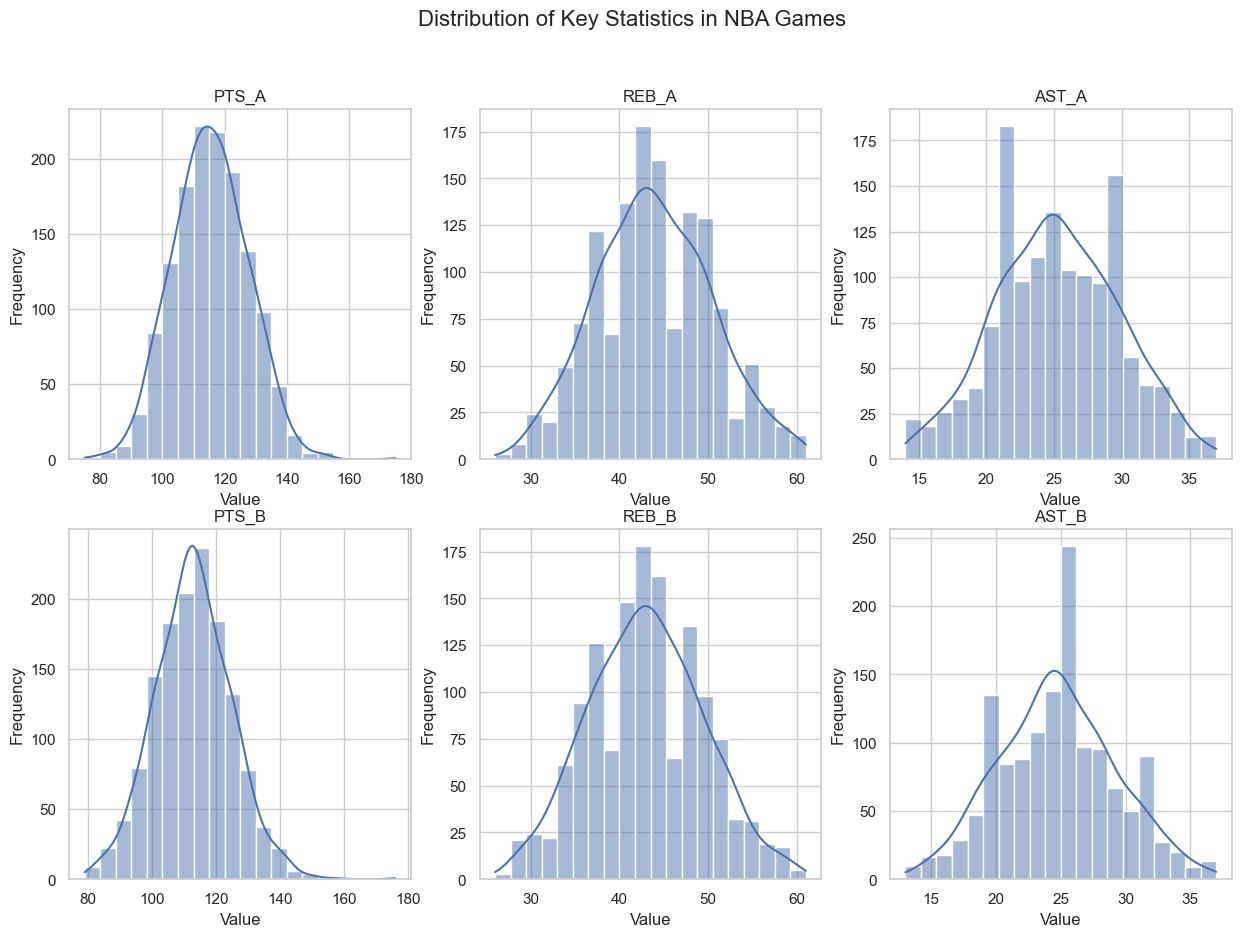

In [24]:
sns.set(style="whitegrid")

columns_to_plot = ['PTS_A', 'REB_A', 'AST_A', 'PTS_B', 'REB_B', 'AST_B']

# plot the distribution of the columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Distribution of Key Statistics in NBA Games', fontsize=16)

for i, col in enumerate(columns_to_plot):
    ax = axes[i//3, i%3]
    sns.histplot(games_merged[col], bins=20, kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

### Observations:
`PTS`: The distribution of the Points scored by the home team and the away team is similar, BUT the home team has a slightly more right-skewed distribution than the away team. It means that the home team has a higher chance of scoring more points than the away team.

`REB`: The distribution of the Rebounds are almost the same for the home team and the away team.

`AST`: The distribution seems a little bit different for the home team and the away team. We can see there are two peaks in the distribution of the home team, while there is only one peak in the distribution of the away team, which occurs at the middle of the distribution.

### T-test 
The mean values of the `PTS_A` and `PTS_B` columns are 115 and 112 respectively, which means the home team has a slightly higher chance of winning the game in an average level. But is the difference significant?

I will use the t-test to figure out whether the difference of PTS is significant.

In [25]:
# Calculate the T-test for the means of two independent samples of scores
t_stat, p_value = ttest_ind(games_merged['PTS_A'], games_merged['PTS_B'])

p_value

3.814080126706906e-08

#### Result: 
The p-value, being much lower than the common significance levels (such as 0.05 or 0.01), indicates that the difference in scores between home and away teams is statistically significant. Combined with histogram observations and t-test results, we can infer that home teams indeed have a scoring advantage, possibly reflecting home-court benefits. 

This significant statistical difference could be influenced by various factors, including home teams' familiarity with the venue, the impact of travel fatigue on away teams, and support from home crowds. This finding provides an interesting starting point for further exploration of the impact of home-court advantage in basketball games.

### 2. About the new features
Next, I will check and analyze `PTS_DIFF`, `SCORING_EFF_A`, `SCORING_EFF_B`, `AST_TOV_RATIO_A`, `AST_TOV_RATIO_B`, `THREE_PT_EFF_A`, `THREE_PT_EFF_B`, which we called **"High-level Metrics"**.

#### 2.1 The `PTS_DIFF` for home team when they win or lose
PTS_DIFF is the difference of the scores of the home team and the away team.

I will use the absolute value of the PTS_DIFF column to check if the home team wins with a large margin or loses with a large margin, or just no significant difference.

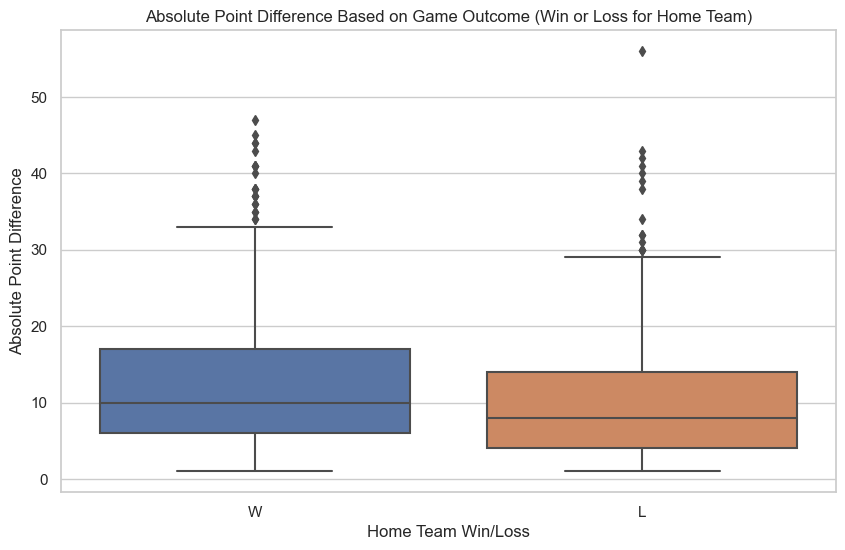

In [26]:
# Calculate the absolute value of the PTS_DIFF column
games_merged['ABS_PTS_DIFF'] = games_merged['PTS_DIFF'].abs()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=games_merged['WL_A'], y=games_merged['ABS_PTS_DIFF'])
plt.title('Absolute Point Difference Based on Game Outcome (Win or Loss for Home Team)')
plt.xlabel('Home Team Win/Loss')
plt.ylabel('Absolute Point Difference')
plt.show()

### Observations:
When the home team wins, the median and interquartile range of the score difference's absolute value tends to be higher, suggesting larger margins in these games. 

In contrast, when the home team loses, even though the median score difference is lower, there are still games with significant margins. 

This box plot suggests that games with a home team victory may have larger margins, possibly indicating stronger home-field control, while games, where the home team loses, are typically closer.

#### 2.2 The `SCORING_EFF` and  `THREE_PT_EFF`
The two metrics are the attacking efficiency of each team, which is the ratio of points to field goals attempts and three-point field goals attempts.

I will try to use scatter plots to check the relationship between the SCORING_EFF and THREE_PT_EFF.

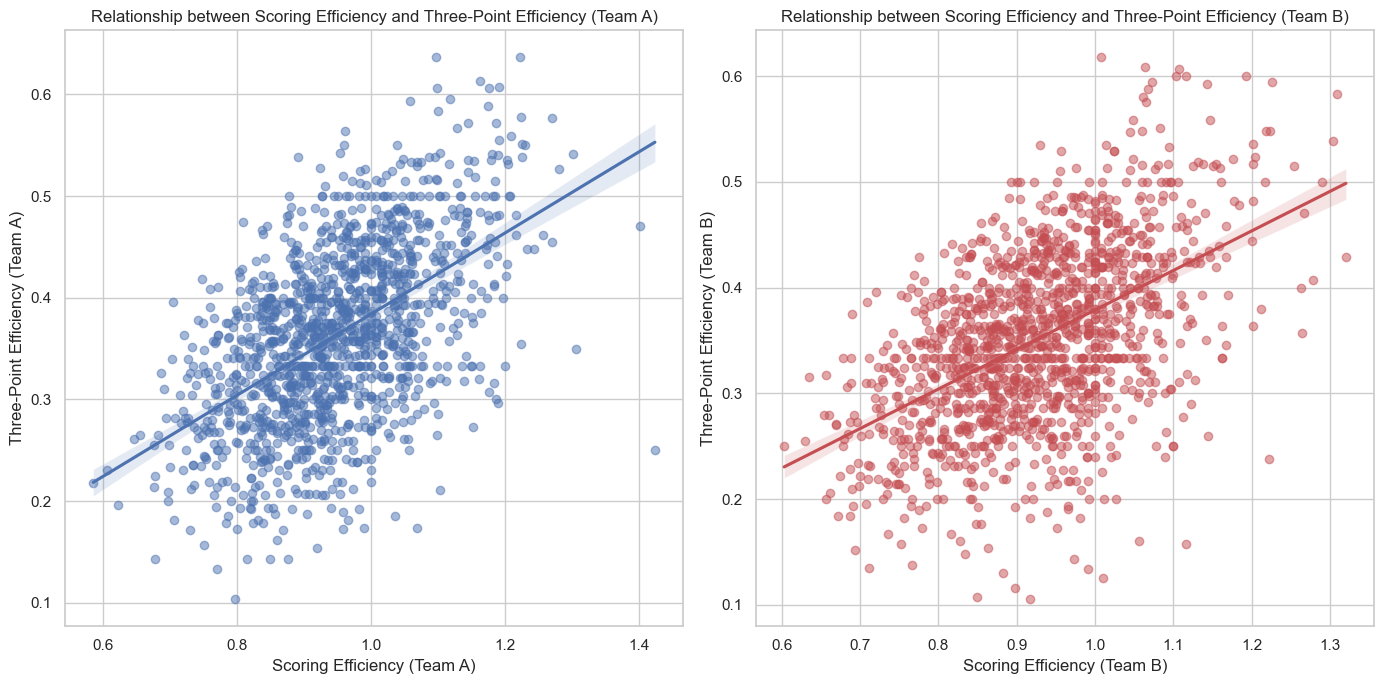

In [27]:
# Home team
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.regplot(x='SCORING_EFF_A', y='THREE_PT_EFF_A', data=games_merged, scatter_kws={'alpha':0.5})
plt.title('Relationship between Scoring Efficiency and Three-Point Efficiency (Team A)')
plt.xlabel('Scoring Efficiency (Team A)')
plt.ylabel('Three-Point Efficiency (Team A)')

# Away team
plt.subplot(1, 2, 2)
sns.regplot(x='SCORING_EFF_B', y='THREE_PT_EFF_B', data=games_merged, scatter_kws={'alpha':0.5}, color='r')
plt.title('Relationship between Scoring Efficiency and Three-Point Efficiency (Team B)')
plt.xlabel('Scoring Efficiency (Team B)')
plt.ylabel('Three-Point Efficiency (Team B)')

plt.tight_layout()
plt.show()


### Observations:
The analysis of the two scatter plots leads to several conclusions:

1. **Positive Correlation**:
   There's a clear positive correlation between scoring efficiency (`SCORING_EFF`) and three-point efficiency (`THREE_PT_EFF`). Better performance in three-point shooting tends to correspond with higher overall scoring efficiency, highlighting the importance of three-point shots in modern basketball strategies.

2. **Strength of Correlation**:
   The slope of the regression line indicates the strength of correlation. Both charts show a relatively steep regression line, suggesting a strong relationship between changes in three-point efficiency and scoring efficiency.

3. **Implication for Scoring Sources**:
   This positive correlation might imply a significant portion of a team's scoring comes from three-point shots, especially in high-efficiency scenarios.

4. **Strategy Formulation**:
   Coaches and strategists can use these findings to emphasize three-point shooting training or to adjust tactics to exploit the role of three-pointers in scoring.

These conclusions offer insights into the components of scoring efficiency and could influence team training and game strategies. However, the correlation doesn't necessarily imply causation and could be influenced by other factors.

As a fan of NBA, I know that the three-point shot is a crucial part of the game in this era. The three-point shot is a high-efficiency shot, which means it is a good choice for the team to score more points. So the team will try to use the three-point shot to score more points, which leads to the positive correlation between the scoring efficiency and the three-point efficiency.

It seems that since Golden State Warriors won the championship in 2015, the three-point shot has become more and more important in the NBA. More and more teams changed the way they play, and they started to use the three-point shot more often.

### 3. Teams Analysis
Next, I will use the `teams` dataframe to do some visualizations.

This dataframe includes the estimated metrics of each team, such as the offensive rating, defensive rating, pace, etc.

These data can be useful when trying to analyze the performance of a team.

First, every regular season has 82 games, and then comes to the playoffs. The "teams" only includes the regular season data.

In [28]:
teams_df.head()

,TEAM_NAME,GP,W,L,W_PCT,E_OFF_RATING,E_DEF_RATING,E_PACE,conference
0,Golden State Warriors,82,44,38,0.537,113.5,111.4,104.2,Western
1,San Antonio Spurs,82,22,60,0.268,107.2,117.7,104.1,Western
2,Indiana Pacers,82,35,47,0.427,111.0,115.4,103.8,Eastern
3,Memphis Grizzlies,82,51,31,0.622,112.3,108.3,103.7,Western
4,Oklahoma City Thunder,82,40,42,0.488,112.3,111.4,103.6,Western


#### 3.1 The Rank of the Teams
Use the `W` column to check the rank of the teams.


In [29]:
# sort the dataframe by the W column
teams_rank = teams_df.sort_values(by='W', ascending=False)
teams_rank.head()

,TEAM_NAME,GP,W,L,W_PCT,E_OFF_RATING,E_DEF_RATING,E_PACE,conference
10,Milwaukee Bucks,82,58,24,0.707,112.8,109.4,102.8,Eastern
20,Boston Celtics,82,57,25,0.695,115.7,108.8,100.6,Eastern
26,Philadelphia 76ers,82,54,28,0.659,115.5,110.2,99.2,Eastern
22,Denver Nuggets,82,53,29,0.646,115.0,111.7,100.3,Western
29,Cleveland Cavaliers,82,51,31,0.622,113.7,107.7,98.0,Eastern
3,Memphis Grizzlies,82,51,31,0.622,112.3,108.3,103.7,Western
11,Sacramento Kings,82,48,34,0.585,117.0,114.1,102.5,Western
24,New York Knicks,82,47,35,0.573,114.9,111.8,99.7,Eastern
17,Phoenix Suns,82,45,37,0.549,112.1,110.1,100.8,Western
19,Brooklyn Nets,82,45,37,0.549,113.0,110.9,100.7,Eastern


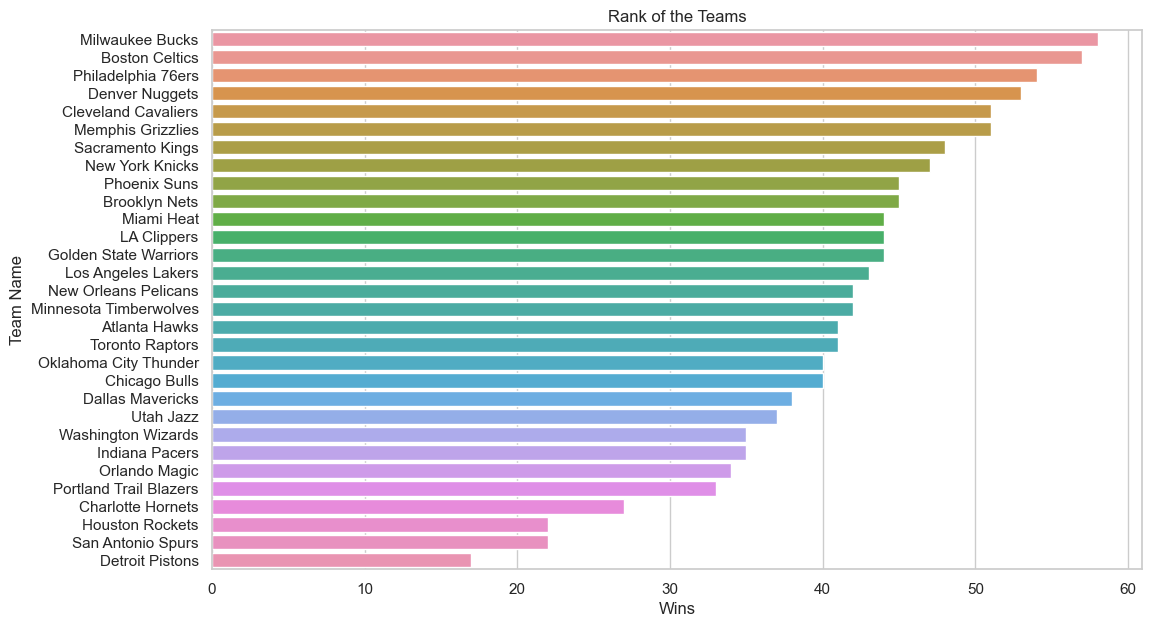

In [30]:
# plot the bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x='W', y='TEAM_NAME', data=teams_rank)
plt.title('Rank of the Teams')
plt.xlabel('Wins')
plt.ylabel('Team Name')
plt.show()

### Observations:
The bar chart shows the rank of the teams based on the number of wins. The more wins the team has, the higher the rank of the team.

The top 5 teams are:
1. Milwaukee Bucks -- 58 wins
2. Boston Celtics -- 57 wins
3. Philadelphia 76ers-- 54 wins
4. Denver Nuggets -- 53 wins
5. Cleveland Cavaliers -- 51 wins

The wins of the top 5 teams are all above 50, and the difference between the top 5 teams is not significant. It means that the top 5 teams are all very strong teams.

Now try to rank these teams by different conferences.

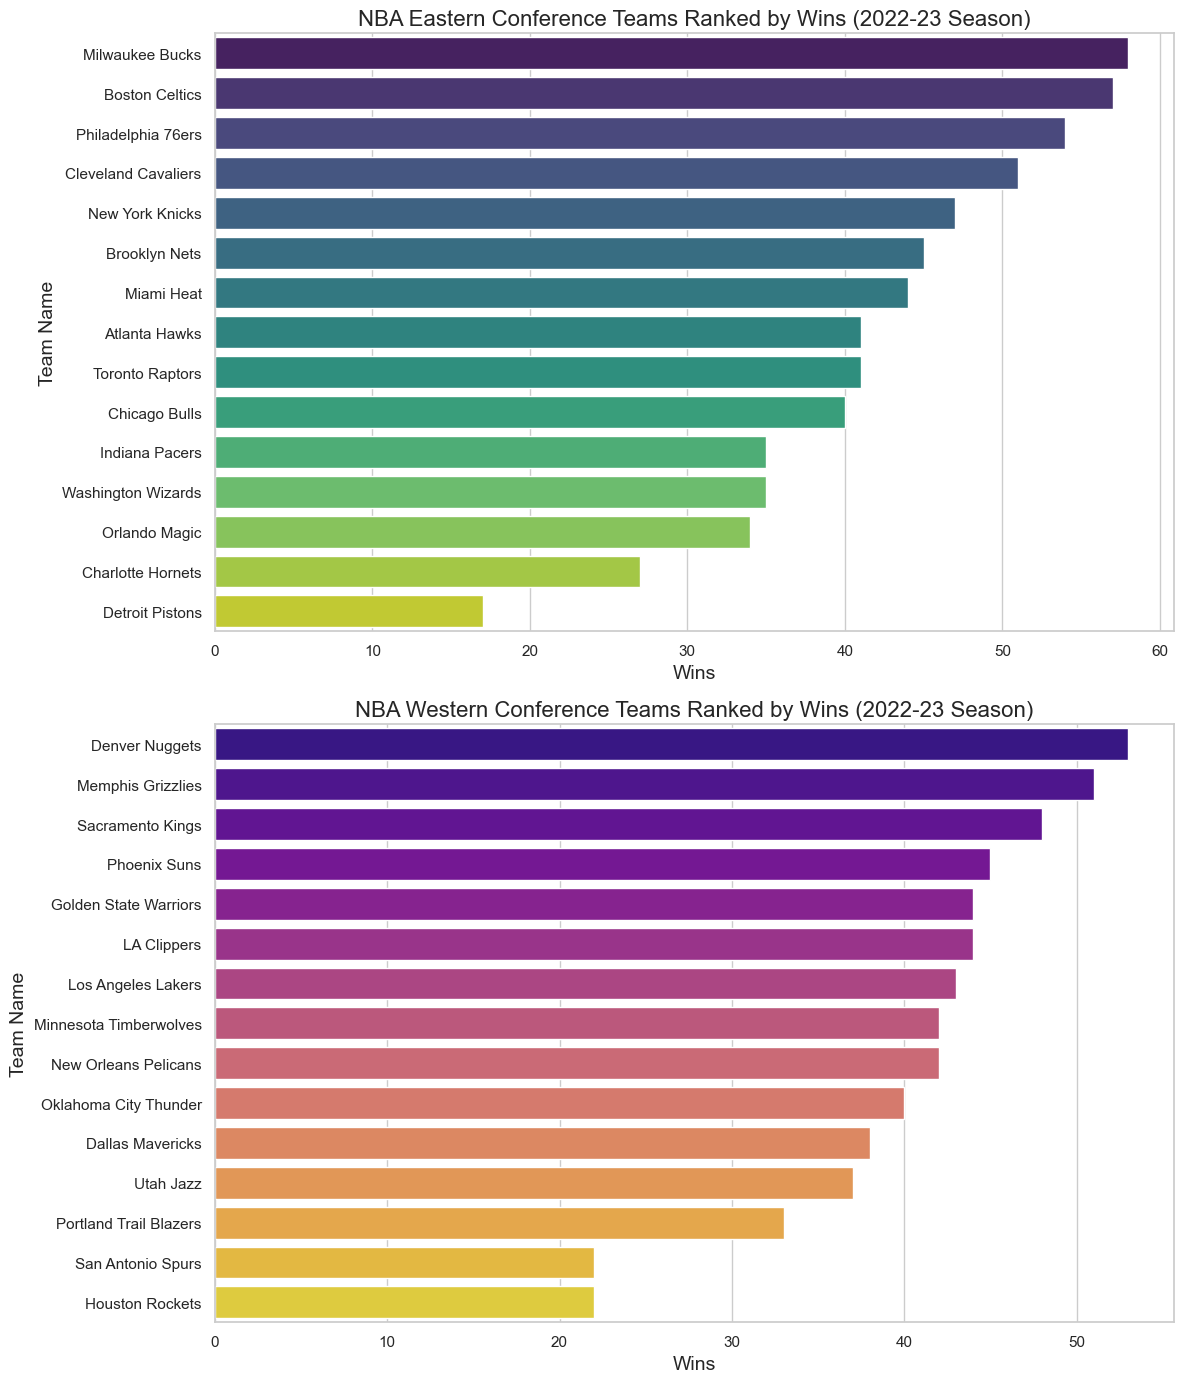

In [31]:
# sort the dataframe by the W column, and filter the eastern/western conference teams
teams_rank_eastern = teams_df[teams_df['conference'] == 'Eastern'].sort_values(by='W', ascending=False)
teams_rank_western = teams_df[teams_df['conference'] == 'Western'].sort_values(by='W', ascending=False)

plt.figure(figsize=(12, 14))

# Eastern Conference
plt.subplot(2, 1, 1)
sns.barplot(x='W', y='TEAM_NAME', data=teams_rank_eastern, palette="viridis")
plt.title('NBA Eastern Conference Teams Ranked by Wins (2022-23 Season)', fontsize=16)
plt.xlabel('Wins', fontsize=14)
plt.ylabel('Team Name', fontsize=14)

# Western Conference
plt.subplot(2, 1, 2)
sns.barplot(x='W', y='TEAM_NAME', data=teams_rank_western, palette="plasma")
plt.title('NBA Western Conference Teams Ranked by Wins (2022-23 Season)', fontsize=16)
plt.xlabel('Wins', fontsize=14)
plt.ylabel('Team Name', fontsize=14)

plt.tight_layout()
plt.show()


### Observations:
Every year after the regular season, the NBA will have the playoffs. The top 8 teams in each conference will enter the playoffs. 

The top 8 teams in the Eastern Conference are:
1. Milwaukee Bucks 
2. Boston Celtics 
3. Philadelphia 76ers
4. Cleveland Cavaliers
5. New York Knicks
6. Brooklyn Nets
7. Miami Heat
8. Atlanta Hawks

The top 8 teams in the Western Conference are:
1. Denver Nuggets
2. Memphis Grizzlies
3. Sacramento Kings
4. Phoenix Suns
5. Golden State Warriors
6. LA Clippers
7. Los Angeles Lakers
8. Minnesota Timberwolves


#### 3.2 The Offensive Rating and Defensive Rating of the Teams
The offensive rating and defensive rating are two important metrics to measure the performance of a team.

The offensive rating is the number of points scored by a team per 100 possessions. The defensive rating is the number of points allowed by a team per 100 possessions.

In [32]:
# Calculate the mean of the E_OFF_RATING and E_DEF_RATING columns
eastern_stats = teams_df[teams_df['conference'] == 'Eastern'][['E_OFF_RATING', 'E_DEF_RATING']].agg(['mean', 'std'])
western_stats = teams_df[teams_df['conference'] == 'Western'][['E_OFF_RATING', 'E_DEF_RATING']].agg(['mean', 'std'])

print('Eastern Conference Offensive Rating: {:.2f} +/- {:.2f}'.format(eastern_stats.loc['mean', 'E_OFF_RATING'], eastern_stats.loc['std', 'E_OFF_RATING']))
print('Eastern Conference Defensive Rating: {:.2f} +/- {:.2f}'.format(eastern_stats.loc['mean', 'E_DEF_RATING'], eastern_stats.loc['std', 'E_DEF_RATING']))

print('Western Conference Offensive Rating: {:.2f} +/- {:.2f}'.format(western_stats.loc['mean', 'E_OFF_RATING'], western_stats.loc['std', 'E_OFF_RATING']))
print('Western Conference Defensive Rating: {:.2f} +/- {:.2f}'.format(western_stats.loc['mean', 'E_DEF_RATING'], western_stats.loc['std', 'E_DEF_RATING']))


Eastern Conference Offensive Rating: 111.99 +/- 2.69
Eastern Conference Defensive Rating: 111.51 +/- 2.37
Western Conference Offensive Rating: 112.23 +/- 2.45
Western Conference Defensive Rating: 112.66 +/- 2.69


### Observations:
The mean of the offensive rating and defensive rating of the Eastern Conference are both lower than the Western Conference, which means that the teams in the Western Conference have a better performance in an average level.

However, it does not mean that the teams in the Western Conference are better than the teams in the Eastern Conference. 

As we know that already, in 22-23 season, Milwaukee Bucks won the championship, and they are in the Eastern Conference. So the offensive rating and defensive rating are not the only metrics to measure the performance of a team.

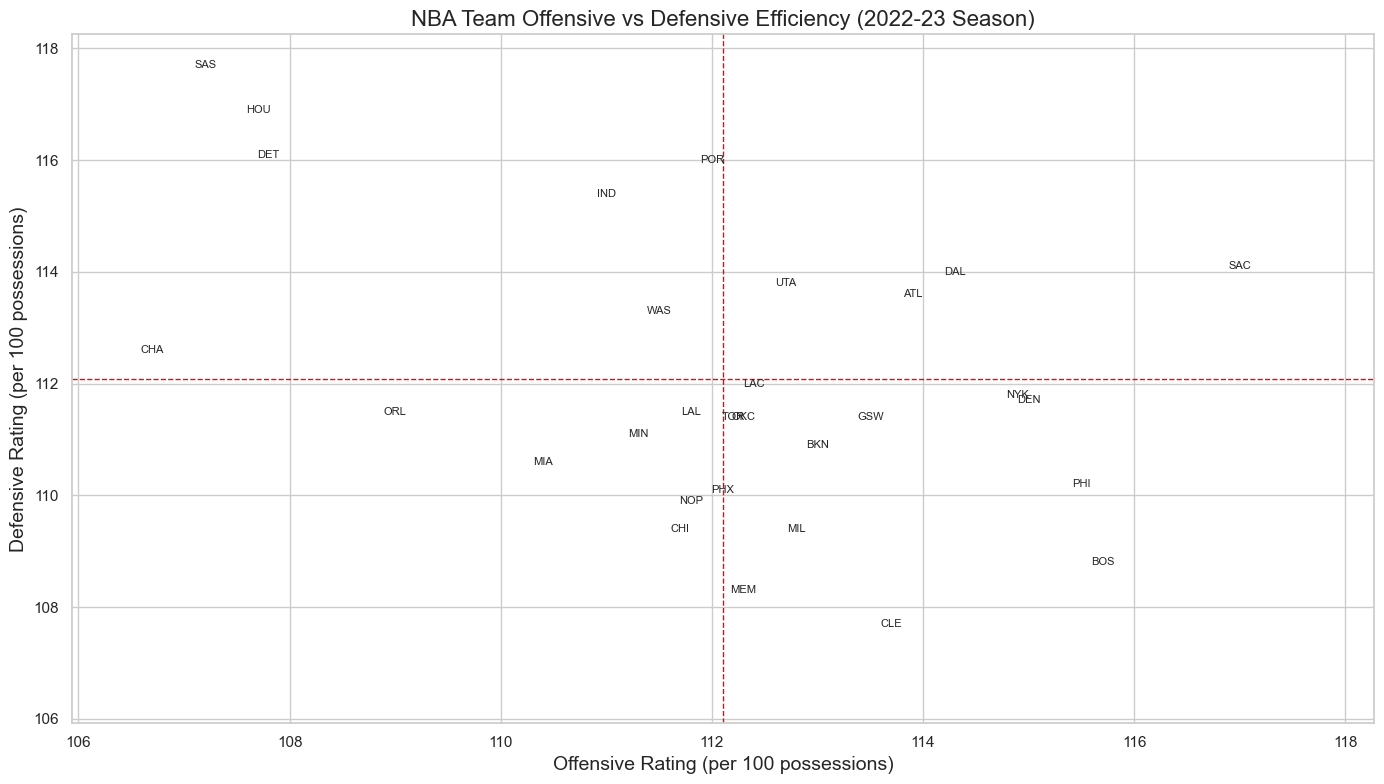

In [33]:
# the mean of the E_OFF_RATING and E_DEF_RATING columns
mean_def_rating = teams_df['E_DEF_RATING'].mean()
mean_off_rating = teams_df['E_OFF_RATING'].mean()

# SET abbreviation for each team
team_abbreviations = {
    "Golden State Warriors": "GSW",
    "San Antonio Spurs": "SAS",
    "Indiana Pacers": "IND",
    "Memphis Grizzlies": "MEM",
    "Oklahoma City Thunder": "OKC",
    "Chicago Bulls": "CHI",
    "Miami Heat": "MIA",
    "Charlotte Hornets": "CHA",
    "Utah Jazz": "UTA",
    "Cleveland Cavaliers": "CLE",
    "New Orleans Pelicans": "NOP",
    "Detroit Pistons": "DET",
    "Orlando Magic": "ORL",
    "Minnesota Timberwolves": "MIN",
    "Washington Wizards": "WAS",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "Denver Nuggets": "DEN",
    "Phoenix Suns": "PHX",
    "Brooklyn Nets": "BKN",
    "Boston Celtics": "BOS",
    "Philadelphia 76ers": "PHI",
    "Los Angeles Lakers": "LAL",
    "Milwaukee Bucks": "MIL",
    "Toronto Raptors": "TOR",
    "Atlanta Hawks": "ATL",
    "New York Knicks": "NYK",
    "LA Clippers": "LAC",
    "Dallas Mavericks": "DAL",
    "Houston Rockets": "HOU"
    
    
}

teams_df['ABBREVIATION'] = teams_df['TEAM_NAME'].apply(lambda name: team_abbreviations.get(name, name[:3].upper()))

# plot the scatter plot, use the abbreviation as the label
plt.figure(figsize=(14, 8))

for index, row in teams_df.iterrows():
    plt.text(row['E_OFF_RATING'], row['E_DEF_RATING'], row['ABBREVIATION'], fontsize=8, ha='center', va='center')

# set the mean of the E_OFF_RATING and E_DEF_RATING columns as the reference line
plt.axhline(mean_def_rating, color='red', linestyle='--', lw=1)
plt.axvline(mean_off_rating, color='red', linestyle='--', lw=1)


plt.title('NBA Team Offensive vs Defensive Efficiency (2022-23 Season)', fontsize=16)
plt.xlabel('Offensive Rating (per 100 possessions)', fontsize=14)
plt.ylabel('Defensive Rating (per 100 possessions)', fontsize=14)

plt.tight_layout()
plt.show()

### Observations:
I use the mean values of the offensive rating and defensive rating as the reference line. The teams above the reference line have a better defensive rating than the average level, and the teams on the right side of the reference line have a better offensive rating than the average level.

The teams in the first quadrant have a better offensive rating and defensive rating than the average level, which means these teams are strong teams. The teams in the third quadrant have a worse offensive rating and defensive rating than the average level, which means these teams are weak teams.

From the plot, we can see that the Sacramento Kings have the best offensive rating, and the San Antonio Spurs have the best defensive rating.

Charlotte Hornets has the worst performance in offence, and the Cleveland Cavaliers has the worst performance in defence.

However, Cavaliers was the fourth seed in the Eastern Conference in the 2022-23 season, which means we can not only use the offensive rating and defensive rating to measure the performance of a team.

# STEP 4 - Ask Questions


## 4.1 What are the most important metrics to measure the performance of a team? 
Use the "games_merged" dataframe

### 1. Explore the correlation between the metrics
First, I will focus on the metrics that are related to the performance of a team, such as the points, rebounds, assists, steals, blocks, turnovers, personal fouls, etc.

Then, calculate the correlation matrix and plot the heatmap.

Finally, I will choose the metrics that have a high correlation with the target value, which is the `WL_A_Binary` column. The more the correlation value is close to 1, the more the metric is related to the target value--the win or loss of the home team.

In [34]:
# data preprocessing
# transform the WL_A and WL_B columns to binary columns, 0 means loss, 1 means win
games_merged['WL_A_Binary'] = (games_merged['WL_A'] == 'W').astype(int)
games_merged['WL_B_Binary'] = (games_merged['WL_B'] == 'W').astype(int)

# choose right metrics for the analysis
columns_of_interest = ['AST_A', 'OREB_A','DREB_A','TOV_A', 'FGM_A','FG3M_A','BLK_A','STL_A','PF_A','WL_A_Binary']

data_analysis = games_merged[columns_of_interest]

# calculate the correlation matrix
correlation_matrix = data_analysis.corr()

# target value is the WL_A_Binary column, only focus on the correlation between the target value and other columns
wl_correlation_a = correlation_matrix['WL_A_Binary'].sort_values(ascending=False)
wl_correlation_a

WL_A_Binary    1.000000
FGM_A          0.372603
DREB_A         0.330184
FG3M_A         0.275227
AST_A          0.274821
STL_A          0.141981
BLK_A          0.100284
OREB_A         0.001621
PF_A          -0.078142
TOV_A         -0.092008
Name: WL_A_Binary, dtype: float64

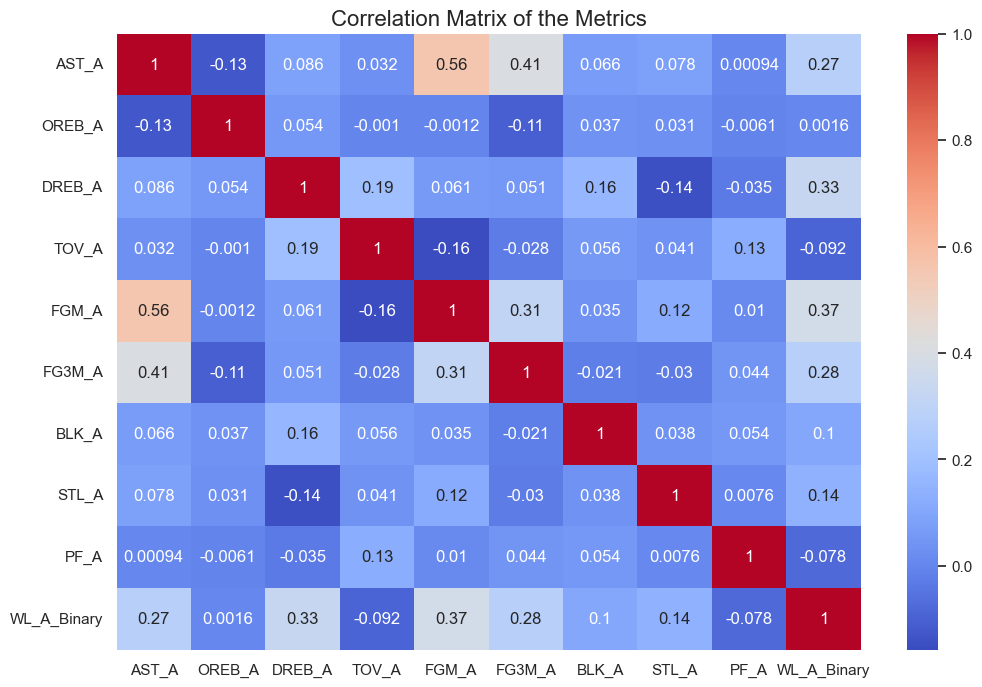

In [35]:
# plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of the Metrics', fontsize=16)
plt.show()

### Observations:
`FGM_A` and `FG3M_A` are both have high positive correlations with `WL_A_Binary`. It is straightforward to understand that the more you goals, the more likely you will win the game.

Out of my expectation, `DREB_A` which means the defensive rebounds of the home team, has a high positive correlation with `WL_A_Binary`. And it is much higher than the correlation between `OREB_A` and `WL_A_Binary`. It means that the defensive rebounds are much more important than the offensive rebounds. As a result, I will consider the defensive rebounds as the most important metric to measure the performance of a team. (Do not consider the direct metrics such as points, goals, etc.)

`AST_A` has a higher correlation with `WL_A_Binary` than `BLK_A` and `STL_A`, which means the assists may be more important than the blocks and steals when measuring the performance of a team.

Both the `TOV_A` and `PF_A` columns have a negative correlation with `WL_A_Binary`, which means the more turnovers and personal fouls the team has, the more likely they will lose the game.

### 2. Model the data to predict the win or loss of the home team

I will try to use some of the metrics to predict the win or loss of the home team.

`FGM_A`, `FG3M_A`, `DREB_A`, `AST_A`, `STL_A`, `TOV_A` will be the features of the model, and `WL_A_Binary` will be the target value.

Reason why I don't choose `BLK_A` and `PF_A`:
- `BLK_A` and `PF_A` have a lower correlation with `WL_A_Binary` than `AST_A`, `STL_A`, and `TOV_A`.
- I think that blocks in basketball are not as important as assists or steals. When blocking the opponent's shot, the ball may stil be in the opponent's hands, and the opponent can still score. But when you steal the ball from the opponent, you can get the ball and have a chance to score. Steals can also change the pace of the game, which is very important.

In [36]:
# choose the features
selected_features = ['FGM_A', 'FG3M_A', 'DREB_A', 'AST_A', 'TOV_A','STL_A']

# get a new dataframe
data_analysis = games_merged[selected_features + ['WL_A_Binary']]

# split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(data_analysis[selected_features], data_analysis['WL_A_Binary'], test_size=0.2, random_state=42)

#### Standardization
I will use the standardization to scale the data. It will help the model to fit the data better, especially for some models such as SVM which are sensitive to the scale of the data.

In [37]:
# Standardization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [38]:
# Logistic Regression for binary classification
logreg_new = LogisticRegression(random_state=42)
logreg_new.fit(X_train_std, y_train)

# predict the test set
y_pred = logreg_new.predict(X_test_std)

# calculate the accuracy and get the classification report
accuracy_new = accuracy_score(y_test, y_pred)
classification_rep_new = classification_report(y_test, y_pred)

print('Accuracy: {:.2f}'.format(accuracy_new))
print('Classification Report:\n', classification_rep_new)

Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.64      0.69       118
           1       0.76      0.85      0.80       159

    accuracy                           0.76       277
   macro avg       0.76      0.74      0.75       277
weighted avg       0.76      0.76      0.75       277


### Observations:
I use the logistic regression model to predict the win or loss of the home team. The accuracy of the model is 0.76, which is not bad. The F1-score of the model is 0.69 for the loss class and 0.80 for the win class, which means the model is better at predicting the win class than the loss class.

In [39]:
# Use SVM to create a model
svm_new = SVC(random_state=42)
svm_new.fit(X_train_std, y_train)

# predict the test set
y_pred = svm_new.predict(X_test_std)

# calculate the accuracy and get the classification report
accuracy_new = accuracy_score(y_test, y_pred)
classification_rep_new = classification_report(y_test, y_pred)

print('Accuracy: {:.2f}'.format(accuracy_new))
print('Classification Report:\n', classification_rep_new)

Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.60      0.66       118
           1       0.74      0.83      0.78       159

    accuracy                           0.73       277
   macro avg       0.73      0.72      0.72       277
weighted avg       0.73      0.73      0.73       277


### Observations:
It seems that the SVM model is not suitable for this dataset. The accuracy of the model is 0.73, which is lower than the logistic regression model. The F1-score of the model is lower than the logistic regression model as well.

### Conclusion:
The two models are both not bad, but the logistic regression model is a little bit better than the SVM model. 

However, we can never predict the win or loss of a team with 100% accuracy. There are too many factors that can affect the result of the game. That's the magic of sports, isn't it?

## 4.2 Can we classify the teams into different kinds of teams based on some metrics?
Use the "games_merged" dataframe

### 1. Which features should we choose?
First, group the data by the team name and calculate the mean of the features. Then choose the features that are related to the performance of a team, such as the points, rebounds, assists, steals, blocks, turnovers, personal fouls, etc.

Finally, I will use the PCA to reduce the dimension of the data to 5, and then use the K-means to cluster the data.

In [40]:
# Choose the useful numeric features
clustering_features = ['TEAM_NAME_A','PTS_A', 'FGM_A', 'FG3M_A', 'DREB_A', 'AST_A', 'STL_A', 'BLK_A', 'TOV_A', 'PF_A']
clustering_data = games_merged[clustering_features]

# group by the team name and calculate the mean of the features
clustering_data = clustering_data.groupby('TEAM_NAME_A').mean()
clustering_data.sort_values(by='PTS_A', ascending=False, inplace=True)
clustering_data.head()

,PTS_A,FGM_A,FG3M_A,DREB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A
TEAM_NAME_A,,,,,,,,,
Sacramento Kings,122.829787,44.276596,13.872340,32.510638,26.617021,7.021277,3.340426,12.851064,19.744681
Oklahoma City Thunder,120.238095,44.333333,12.261905,32.571429,24.404762,8.595238,4.285714,12.571429,20.857143
Atlanta Hawks,119.977778,45.422222,10.888889,34.422222,25.266667,7.155556,4.977778,12.244444,17.955556
Golden State Warriors,119.117647,43.333333,16.686275,35.588235,29.098039,7.529412,3.803922,14.862745,21.274510
Memphis Grizzlies,118.673913,44.456522,12.217391,35.086957,26.369565,8.456522,5.717391,12.260870,18.804348


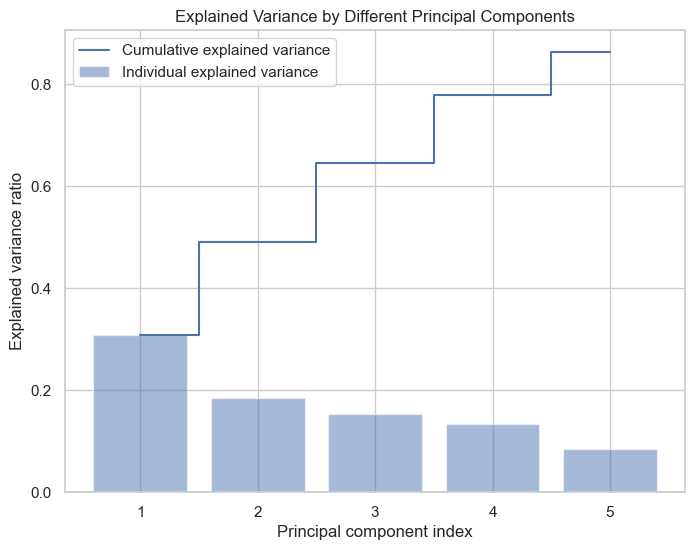

(array([0.30739013, 0.18414996, 0.15338381, 0.13344331, 0.08461611]),
 array([0.30739013, 0.49154009, 0.64492389, 0.7783672 , 0.86298331]))

In [41]:
# choose the features
features = clustering_data.iloc[:, 0:]

# Standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA to reduce the dimension to 5
pca = PCA(n_components=5, random_state=42)
pca.fit(features_scaled)

# explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title('Explained Variance by Different Principal Components')
plt.show()

explained_variance_ratio, np.cumsum(explained_variance_ratio)

### Observations:
The first 5 principal components explain 87% of the variance in the data. So I will choose the first 5 principal components as the features for the K-means clustering.

In [42]:
# Analyze the first 5 principal components, get the loadings
pca_df = pd.DataFrame(pca.components_, columns=features.columns, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
pca_df

,PTS_A,FGM_A,FG3M_A,DREB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A
PC1,0.511345,0.498908,0.280029,0.392584,0.421831,-0.120319,0.034158,0.025007,-0.250734
PC2,0.063713,0.296351,-0.468008,-0.102932,-0.013364,0.536113,0.401772,-0.419600,-0.231103
PC3,0.194035,0.174638,0.105826,-0.354749,0.310523,0.453057,-0.045719,0.297570,0.634415
PC4,0.305331,0.063936,0.300760,-0.370608,-0.230962,0.013927,-0.507211,-0.603091,-0.018963
PC5,0.034916,-0.226926,0.519097,-0.106801,0.014605,-0.139438,0.720146,-0.302372,0.191630


### Observations:
The principal components (PCs) analysis of the basketball team data suggests:

- **PC1**: Dominated by high positive loadings on PTS_A (average points), FGM_A (average field goals made), AST_A (average assists), and DREB_A (average defensive rebounds), indicating PC1 might represent overall offensive strength and ball control ability.

- **PC2**: Influenced mainly by loadings on FG3M_A (average three-point field goals made) negatively, and STL_A (average steals) and BLK_A (average blocks) positively, suggesting a relation to defensive abilities and inside play, while reflecting lower dependence on three-point shots.

- **PC3**: Characterized by high positive loading on PF_A (average fouls) and a negative loading on DREB_A, possibly indicating the team's defensive style and physicality.

- **PC4**: Mainly affected by negative loadings on TOV_A (average turnovers) and BLK_A, suggesting aggressiveness on defense and stability in offense.

- **PC5**: Characterized by high positive loadings on FG3M_A and BLK_A, indicating the team's proficiency in three-point shooting and defensive aspects.

E:\Programming\anaconda3\envs\cuda1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\Programming\anaconda3\envs\cuda1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\Programming\anaconda3\envs\cuda1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\Programming\anaconda3\envs\cuda1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread

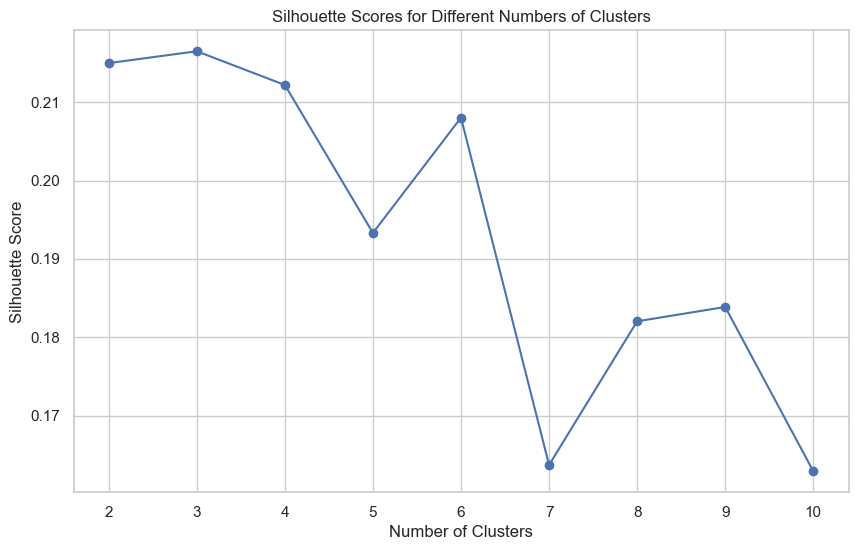

In [43]:
# Applying PCA transformed data
features_pca = pca.transform(features_scaled)

# Finding the optimal number of clusters using silhouette score
silhouette_scores = []
k_values = range(2, 11)  # Trying different numbers of clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    score = silhouette_score(features_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()


### Observations:
Silhouette score is a metric used to measure the quality of clusters. The score ranges from -1 to 1, with higher values indicating better clustering performance.

The plot shows that when number of Clusters is 3, the silhouette score is the highest. So I will choose 3 as the number of clusters.

### 2. Can we classify the teams into different kinds with different characteristics?

In [44]:
# Performing KMeans clustering with the optimal number of clusters (3)
kmeans_optimal = KMeans(n_clusters=3, random_state=49)
kmeans_optimal.fit(features_pca)

# Getting the cluster labels
cluster_labels = kmeans_optimal.labels_

# Adding the cluster labels to the original data
clustering_data['Cluster'] = cluster_labels
clustering_data.head()

E:\Programming\anaconda3\envs\cuda1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
E:\Programming\anaconda3\envs\cuda1\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PTS_A,FGM_A,FG3M_A,DREB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,Cluster
TEAM_NAME_A,,,,,,,,,,
Sacramento Kings,122.829787,44.276596,13.872340,32.510638,26.617021,7.021277,3.340426,12.851064,19.744681,1
Oklahoma City Thunder,120.238095,44.333333,12.261905,32.571429,24.404762,8.595238,4.285714,12.571429,20.857143,1
Atlanta Hawks,119.977778,45.422222,10.888889,34.422222,25.266667,7.155556,4.977778,12.244444,17.955556,2
Golden State Warriors,119.117647,43.333333,16.686275,35.588235,29.098039,7.529412,3.803922,14.862745,21.274510,1
Memphis Grizzlies,118.673913,44.456522,12.217391,35.086957,26.369565,8.456522,5.717391,12.260870,18.804348,2


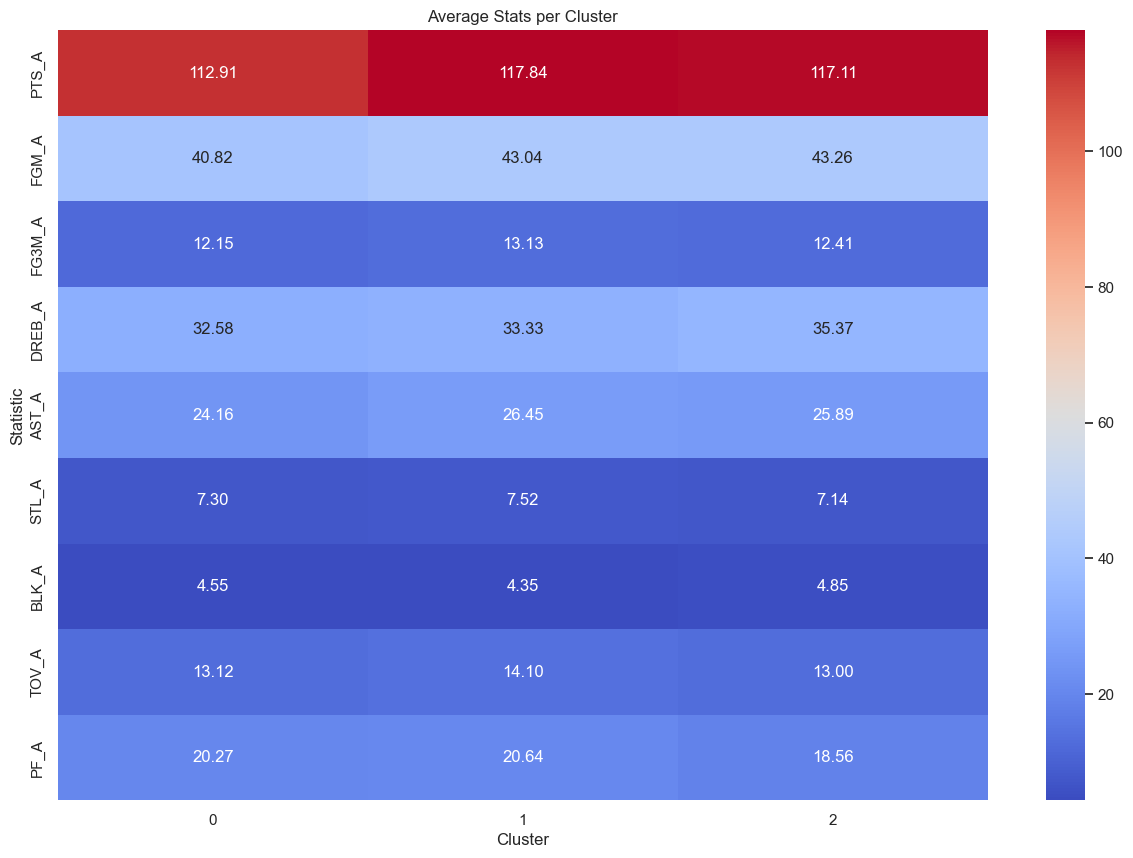

In [45]:
# Calculating the mean of features for each cluster
cluster_means = clustering_data.groupby('Cluster').mean()

# Plotting the cluster means for each feature
plt.figure(figsize=(15, 10))
sns.heatmap(cluster_means.T, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Stats per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Statistic')
plt.show()

In [46]:
# Grouping the teams by their clusters and listing them
clustering_data.reset_index(inplace=True)
clustered_teams = clustering_data.groupby('Cluster')['TEAM_NAME_A'].apply(list)

# Converting the Series to a DataFrame for better readability
clustered_teams_df = clustered_teams.reset_index(name='Teams')
clustered_teams_df


,Cluster,Teams
0,0,"[New York Knicks, Portland Trail Blazers, Dall..."
1,1,"[Sacramento Kings, Oklahoma City Thunder, Gold..."
2,2,"[Atlanta Hawks, Memphis Grizzlies, Boston Celt..."


### Observations:
Based on the intensity of the colors in the heatmap, we can analyze the characteristics of each cluster:

- **Cluster 0**: Lower in scoring (PTS/A), with relatively lower assists (AST/A) and defensive rebounds (DREB/A). Higher turnovers (TOV/A) might suggest issues with ball control and transition in offense and defense.
- **Cluster 1**: Highest in scoring (PTS/A) and field goals made (FGM/A), indicating a focus on offense. Despite not the highest in three-pointers made (FG3M/A), these teams might rely more on two-pointers.
- **Cluster 2**: Highest in defensive rebounds (DREB/A), suggesting strong defensive rebounding. Good in assists (AST/A), indicating effective team coordination. Also highest in blocks (BLK/A), emphasizing defensive strength.

Overall, teams in Cluster 1 might be strong in scoring, Cluster 2 shows defensive rebounding and blocking strength, while Cluster 0 seems average in offense and ball control. This analysis helps understand team characteristics and can aid in strategy formulation and game preparation.

Let’s see some of the teams in each cluster:
Cluster 0: Miami Heat, New York Knicks, Orlando Magic;
Cluster 1: Golden State Warriors, Sacramento Kings,  Minnesota Timberwolves;
Cluster 2: Los Angeles Lakers, Memphis Grizzlies, Boston Celtics.

### 3. Can we find which cluster has the highest win rate?

In [47]:
# add the W_PCT column to the dataframe
clustering_data['W_PCT'] = clustering_data['TEAM_NAME_A'].apply(lambda x: teams_df[teams_df['TEAM_NAME'] == x]['W_PCT'].values[0])

clustering_data.sort_values(by='W_PCT', ascending=False, inplace=True)
clustering_data.head(5)

,TEAM_NAME_A,PTS_A,FGM_A,FG3M_A,DREB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,Cluster,W_PCT
7,Milwaukee Bucks,118.319149,43.063830,14.957447,37.276596,25.297872,6.340426,4.382979,14.212766,18.553191,2,0.707
5,Boston Celtics,118.666667,42.500000,15.666667,36.277778,25.925926,6.388889,4.888889,13.018519,17.888889,2,0.695
22,Philadelphia 76ers,112.812500,39.750000,12.875000,32.604167,25.145833,8.083333,4.812500,12.729167,20.437500,0,0.659
8,Denver Nuggets,117.259259,43.666667,12.129630,34.592593,27.944444,7.444444,4.277778,12.870370,18.925926,2,0.646
25,Cleveland Cavaliers,111.760870,41.195652,11.826087,32.021739,25.391304,7.347826,4.652174,13.021739,19.195652,0,0.622


In [48]:
# Analyzing the win rate (W_PCT) across clusters
# Calculating the mean win rate for each cluster
winrate_by_cluster = clustering_data.groupby('Cluster')['W_PCT'].mean().reset_index()

# Sorting the clusters by win rate in descending order
winrate_by_cluster_sorted = winrate_by_cluster.sort_values(by='W_PCT', ascending=False)
winrate_by_cluster_sorted

,Cluster,W_PCT
2,2,0.576125
1,1,0.472500
0,0,0.472143


### Observations:
Cluster 2 has the highest win rate (0.57), and Cluster 0 has the lowest win rate (0.47).

Based on the analysis, Cluster 2 teams might be more successful in strategy and execution, likely due to their comprehensive performance in various statistics. While Clusters 1 and 0 show differences in their stats, these differences don't seem to translate into a significant advantage in win rates. Next steps could involve further exploration of these clusters' characteristics and an attempt to understand why Cluster 2 teams have a higher win rate.


### 4. Why Cluster 2 has the highest win rate?

In [49]:
# Calculate the mean of all statistical features for each cluster
cluster_stats_means = clustering_data.groupby('Cluster').mean().drop(columns=['W_PCT'])

# Sorting the index to ensure that the clusters are in order
cluster_stats_means.reset_index(inplace=True)

# Display the mean stats for each cluster
cluster_stats_means


C:\Users\yhb\AppData\Local\Temp\ipykernel_42084\4275611132.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_stats_means = clustering_data.groupby('Cluster').mean().drop(columns=['W_PCT'])


,Cluster,PTS_A,FGM_A,FG3M_A,DREB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A
0,0,112.908916,40.824139,12.148006,32.579968,24.159145,7.304247,4.550524,13.122006,20.271609
1,1,117.839266,43.041523,13.131793,33.332944,26.445326,7.520884,4.345476,14.095293,20.635577
2,2,117.111900,43.264181,12.413675,35.373745,25.892587,7.135642,4.853518,13.003420,18.560151


### Observations:
Cluster 0: Teams in this cluster have lower averages in points scored (PTS/A) and field goals made (FGM/A), suggesting less offensive efficiency compared to other clusters. Additionally, they have the highest fouls (PF/A), which might impact their defensive efficiency and win rates.

Cluster 1: These teams show the highest average in scoring (PTS/A), indicating strong offensive performance. However, they also have the highest turnovers (TOV/A), possibly indicating issues with ball control despite strong scoring abilities.

Cluster 2: Teams here excel in defensive rebounds (DREB/A), helping limit opponents' second-chance points, and lead in blocks (BLK/A), reflecting strong defensive capabilities. They also commit the fewest fouls, indicating effective defense with less cost.

Overall, Cluster 2 teams seem to balance offensive efficiency with solid defense, particularly in rebounding and reducing fouls, possibly contributing to their higher average win rates. In contrast, Clusters 0 and 1, despite excelling in some areas, may have weaknesses in key stats affecting their overall win rates.

## 4.3 What about PACE? Does it have a significant impact on the game?
Use thee "team_df" dataframe to do the analysis.

Pace means that the number of offensive possessions per 48 minutes by a team. It is a metric to measure the speed of the game.
A team who has a higher pace will have more offensive possessions.

### 1. Does pace have an impact on the Offensive Rating and Defensive Rating?

In [50]:
# 1. Correlation analysis between E_PACE and E_OFF_RATING
corr_pace_off = pearsonr(teams_df['E_PACE'], teams_df['E_OFF_RATING'])

# 2. Correlation analysis between E_PACE and E_DEF_RATING
corr_pace_def = pearsonr(teams_df['E_PACE'], teams_df['E_DEF_RATING'])

print('Correlation between E_PACE and E_OFF_RATING: {:.2f}'.format(corr_pace_off[0]))
print('Correlation between E_PACE and E_DEF_RATING: {:.2f}'.format(corr_pace_def[0]))

Correlation between E_PACE and E_OFF_RATING: -0.32
Correlation between E_PACE and E_DEF_RATING: 0.30


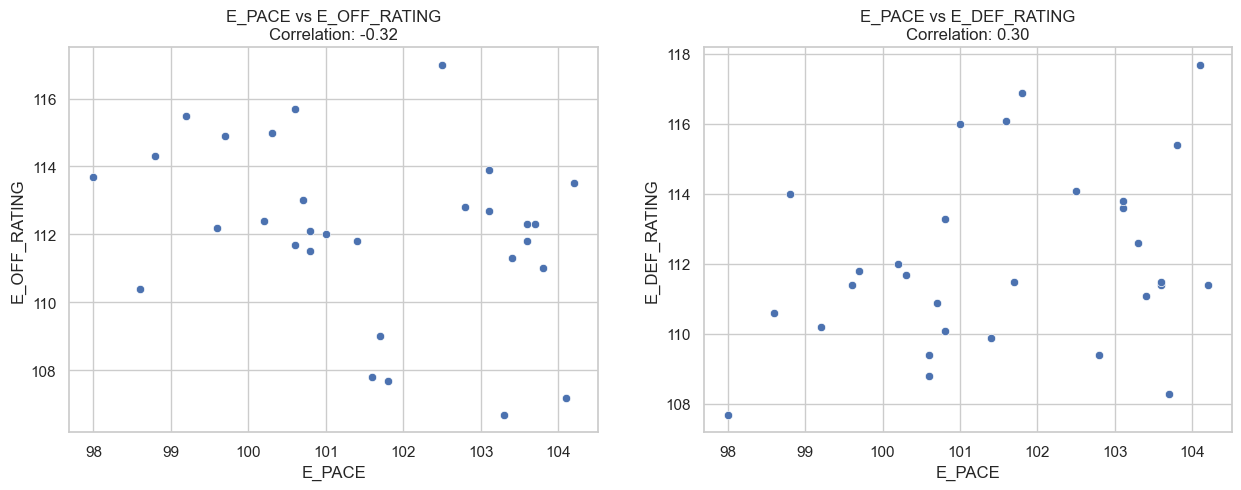

In [51]:
# Plot the scatter plot
# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: E_PACE vs E_OFF_RATING
plt.subplot(1, 2, 1)
sns.scatterplot(x='E_PACE', y='E_OFF_RATING', data=teams_df)
plt.title(f'E_PACE vs E_OFF_RATING\nCorrelation: {corr_pace_off[0]:.2f}')

# Plot 2: E_PACE vs E_DEF_RATING
plt.subplot(1, 2, 2)
sns.scatterplot(x='E_PACE', y='E_DEF_RATING', data=teams_df)
plt.title(f'E_PACE vs E_DEF_RATING\nCorrelation: {corr_pace_def[0]:.2f}');

### Observations:
The correlation between E_PACE and E_OFF_RATING is -0,32,and the correlation between E_PACE and E_DEF_RATING is 0.30. It means that the E_PACE has a moderate correlation with the E_OFF_RATING and E_DEF_RATING.

From the scatter plots, it hard to tell if there is a significant relationship between E_PACE and E_OFF_RATING or E_DEF_RATING. However, we can see that it seems that the teams with a higher E_PACE tend to have a lower E_OFF_RATING and a higher E_DEF_RATING.


### 2. Does pace have an impact on the win rate?


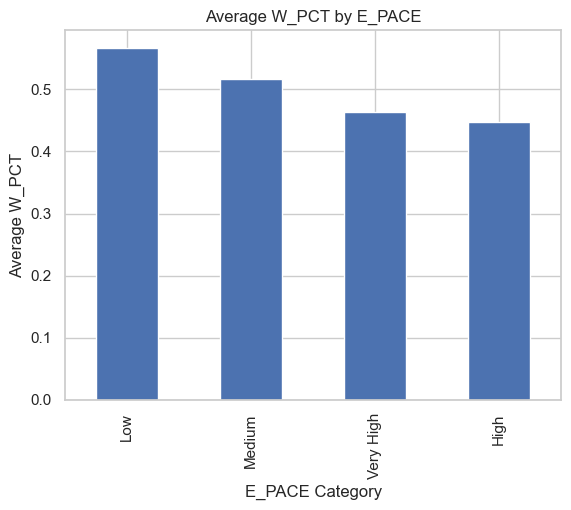

In [52]:
# Dividing E_PACE into bins
teams_df['E_PACE_BINS'] = pd.qcut(teams_df['E_PACE'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

grouped_by_pace = teams_df.groupby(teams_df['E_PACE_BINS'])['W_PCT'].mean().sort_values(ascending=False)
grouped_by_pace.plot(kind='bar')

plt.title('Average W_PCT by E_PACE')
plt.ylabel('Average W_PCT')
plt.xlabel('E_PACE Category')

plt.show()

### Observations:
Based on the bar graph you provided, we can observe the average win rates (W_PCT) across different game pace (E_PACE) categories. The graph displays four pace categories: "Low," "Medium," "High," and "Very High." Here's an analysis:

- Teams in the "Low" pace category have the highest average win rate.
- As pace increases from "Low" to "Medium" and from "Medium" to "High," there's a slight decline in average win rates.
- However, there's an apparent increase in win rates when the pace goes from "High" to "Very High."

This suggests the impact of game pace on win rates is non-linear. We need more analysis to understand the relationship between game pace and win rates.

In [53]:
# Calculate the correlation between E_PACE and W_PCT
w_pct_by_pace = teams_df.groupby('E_PACE_BINS')['W_PCT'].describe()

w_pct_by_pace

,count,mean,std,min,25%,50%,75%,max
E_PACE_BINS,,,,,,,,
Low,8.0,0.567125,0.070580,0.463,0.52775,0.555,0.62800,0.659
Medium,7.0,0.517429,0.096542,0.402,0.45750,0.512,0.54900,0.695
High,7.0,0.447571,0.173268,0.207,0.34150,0.451,0.54250,0.707
Very High,8.0,0.463375,0.116361,0.268,0.40250,0.500,0.52725,0.622


### Observations:
The distribution of teams across each pace category is relatively even, allowing for fair comparison. 

Teams in the "Low" pace category exhibit the highest average win rate coupled with a lower standard deviation, suggesting that their win rates are more concentrated and generally higher across the category.
 
Teams in the "High" pace category have the lowest average win rate, but with the largest standard deviation, indicating significant variability in their performance within this category.

Although the average win rate for teams in the "Medium" pace category is lower than that of the "Low" pace category, the highest win rate within this group reaches 0.695. This suggests that some teams excel under a medium-paced gameplay. I check the data and the team with 0.695 win rate is the Boston Celtics, which is the second seed in the Eastern Conference in the 2022-23 season.

Teams in the "Very High" pace category exhibit a wide range of win rates, but their average win rate is higher than that of the "High" pace category.

## 4.4 Individual Players Analysis
Use the "players_df" dataframe to do the analysis. It contains the data of the players in the 2022-23 season.

First, pick up the players who played over 60 games in the 2022-23 season. Then, convert the data to per game statistics. Finally, do some visualizations.

In [151]:
players_df= pd.read_csv('players_df.csv')
# choose the players who played over 60 games
players_df = players_df[players_df['GP'] > 30]

players_df.head() 

,PLAYER_NAME,Team,Conference,GP,W,L,W_PCT,MIN,PTS,AST,STL,BLK,REB,OREB,DREB,TOV,PF,FGM,FGA,FG3M,FG3A,FTM,FTA,FG_PCT,FG3_PCT,FT_PCT
0,AJ Griffin,Atlanta Hawks,Eastern,72,34,38,0.472,1401.435000,639,73,42,12,153,37,116,42,87,248,533,101,259,42,47,0.465,0.390,0.894
1,Aaron Holiday,Atlanta Hawks,Eastern,63,32,31,0.508,845.256667,247,89,37,12,74,25,49,36,79,92,220,36,88,27,32,0.418,0.409,0.844
2,Bogdan Bogdanovic,Atlanta Hawks,Eastern,54,27,27,0.500,1508.608333,756,150,43,18,165,23,142,65,86,273,611,146,360,64,77,0.447,0.406,0.831
4,Clint Capela,Atlanta Hawks,Eastern,65,35,30,0.538,1730.083333,779,58,45,79,717,258,459,54,139,350,536,0,1,79,131,0.653,0.000,0.603
5,De'Andre Hunter,Atlanta Hawks,Eastern,67,35,32,0.522,2125.630000,1029,94,35,17,284,46,238,82,199,379,822,100,286,171,207,0.461,0.350,0.826


In [152]:
# Columns to convert to per game statistics
columns_to_convert_per_game = ['PTS', 'AST', 'STL', 'BLK', 'REB']

# Converting the selected columns to per game statistics
for col in columns_to_convert_per_game:
    players_df[col + '_per_game'] = players_df[col] / players_df['GP']

# choose the columns
players_df_per_game = players_df[['PLAYER_NAME', 'Team', 'Conference','W'] + [col for col in players_df.columns if col.endswith('_per_game')]+['FG3M']]

players_df_per_game.head()

# players_df_per_game.to_csv('players_df_per_game.csv', index=False)

,PLAYER_NAME,Team,Conference,W,PTS_per_game,AST_per_game,STL_per_game,BLK_per_game,REB_per_game,FG3M
0,AJ Griffin,Atlanta Hawks,Eastern,34,8.875000,1.013889,0.583333,0.166667,2.125000,101
1,Aaron Holiday,Atlanta Hawks,Eastern,32,3.920635,1.412698,0.587302,0.190476,1.174603,36
2,Bogdan Bogdanovic,Atlanta Hawks,Eastern,27,14.000000,2.777778,0.796296,0.333333,3.055556,146
4,Clint Capela,Atlanta Hawks,Eastern,35,11.984615,0.892308,0.692308,1.215385,11.030769,0
5,De'Andre Hunter,Atlanta Hawks,Eastern,35,15.358209,1.402985,0.522388,0.253731,4.238806,100


### 1. Who got the highest recorded stats in the season?
First I will focus on the different stats of the players. Try to find out who got the highest points, rebounds, assists, steals, blocks, turnovers.


In [153]:
# find the top1 player in each stat from players_df_per_game
for col in players_df_per_game.columns:
    if col.endswith('_per_game') or col == 'FG3M':
        print(players_df_per_game[['PLAYER_NAME', col]].sort_values(by=col, ascending=False).head(1))

     PLAYER_NAME  PTS_per_game
343  Joel Embiid     33.075758
      PLAYER_NAME  AST_per_game
342  James Harden     10.655172
    PLAYER_NAME  STL_per_game
474  OG Anunoby      1.910448
           PLAYER_NAME  BLK_per_game
513  Jaren Jackson Jr.           3.0
       PLAYER_NAME  REB_per_game
168  Anthony Davis     12.535714
       PLAYER_NAME  FG3M
143  Klay Thompson   301


### Observations:
In NBA, every season there will be some awards for the players who got the highest stats in the season. For example, the player who got the highest points in the season will get the Points Per Game Leader award.

### 2. What about he MVP ?
MVP means the Most Valuable Player, which is one of the most prestigious awards in NBA. 

Generally, the MVP is the player who got the best performance in the season. However, it is not only about the data, but also about the influence of the player. The MVP is voted by the media and the players. 

I searched the information of the MVP in the 2022-23 season. The MVP is Joel Embiid. Let's see if the data can tell us the same thing.

There were three candidates for the MVP in the 2022-23 season: Joel Embiid, Giannis Antetokounmpo, and Nikola Jokic. Let's see if the data can tell us who is the MVP.

In [154]:
# choose the mvp candidates
mvp_candidates = ['Joel Embiid', 'Giannis Antetokounmpo', 'Nikola Jokic']

# filter the data
players_df_mvp = players_df_per_game[players_df_per_game['PLAYER_NAME'].isin(mvp_candidates)]

players_df_mvp

,PLAYER_NAME,Team,Conference,W,PTS_per_game,AST_per_game,STL_per_game,BLK_per_game,REB_per_game,FG3M
126,Nikola Jokic,Denver Nuggets,Western,48,24.492754,9.826087,1.260870,0.681159,11.840580,57
216,Giannis Antetokounmpo,Milwaukee Bucks,Eastern,47,31.095238,5.698413,0.825397,0.809524,11.777778,47
343,Joel Embiid,Philadelphia 76ers,Eastern,43,33.075758,4.151515,1.000000,1.696970,10.151515,66


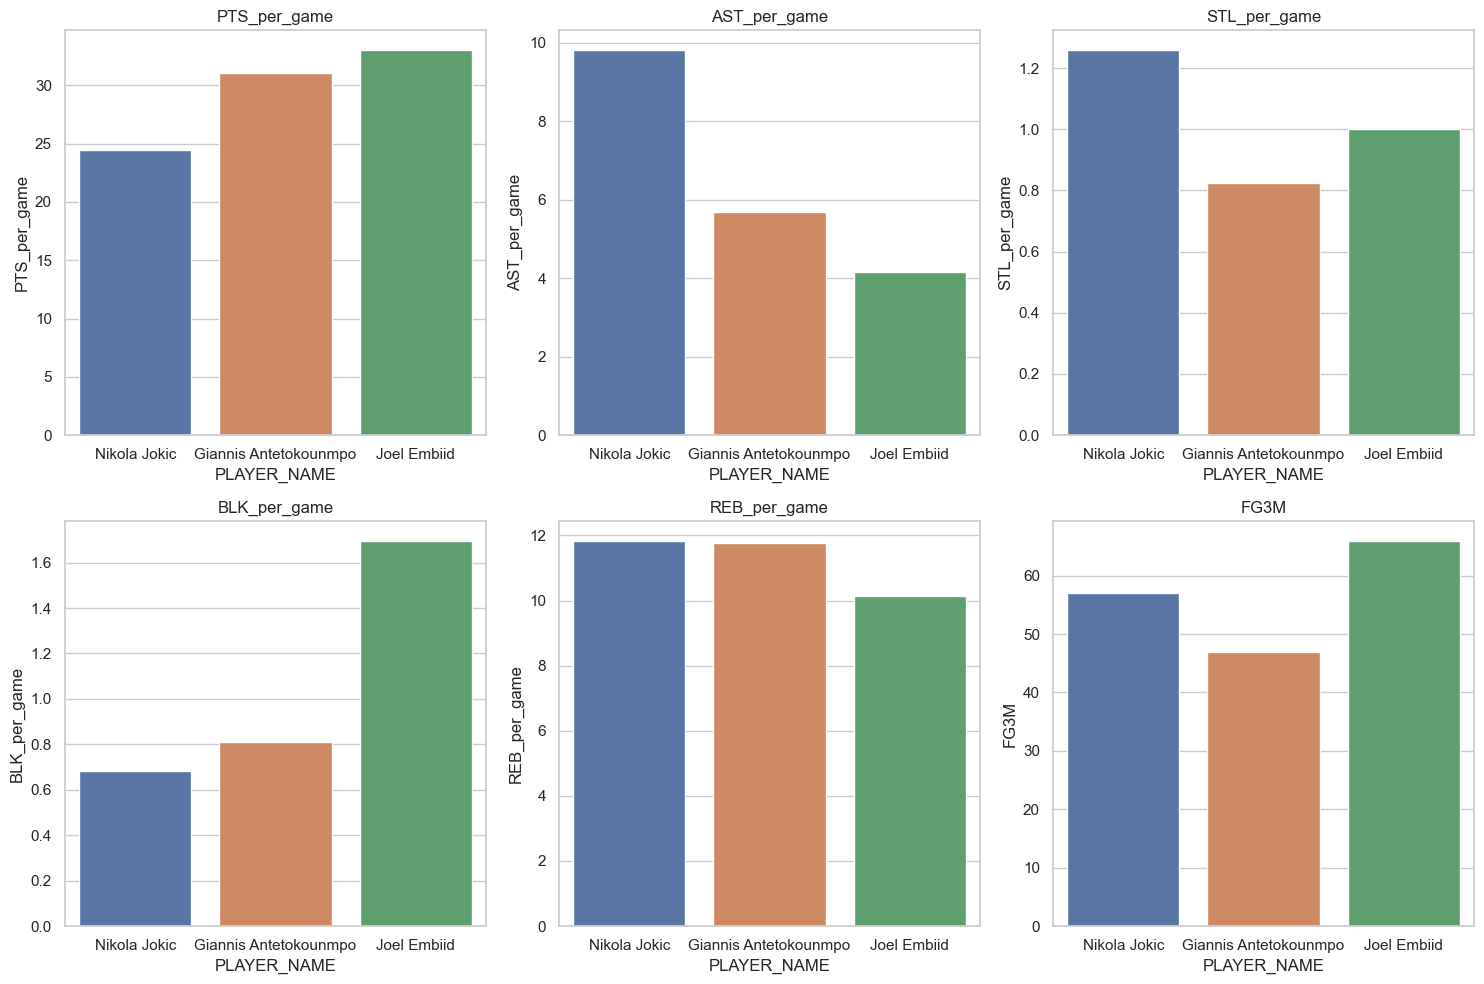

In [155]:
# Preparing the data for plotting with the new dataset
mvp_stats_new = players_df_mvp.set_index('PLAYER_NAME').drop(columns=['Team', 'Conference', 'W'])

# Plotting the statistics for each MVP candidate
plt.figure(figsize=(15, 10))

for i, column in enumerate(mvp_stats_new.columns, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=mvp_stats_new.index, y=mvp_stats_new[column])
    plt.title(column)

plt.tight_layout()
plt.show()

### Observations:

- **Scoring (PTS_per_game)**: Embiid leads, followed by Antetokounmpo and Jokic.
- **Assists (AST_per_game)**: Jokic significantly leads, demonstrating his unique passing ability as a center.
- **Steals (STL_per_game) and Blocks (BLK_per_game)**: Embiid excels in both defensive metrics.
- **Blocks (BLK_per_game)**: Embiid excels in both defensive metrics.
- **Rebounds (REB_per_game)**: All three players are close, with Jokic slightly ahead.
- **Three-pointers Made (FG3M)**: Embiid is slightly ahead.

This data offers a comprehensive assessment of each candidate's skills. While Embiid has scoring and defensive edges, Jokic's all-around ability and Antetokounmpo's scoring and rebounding are notable. 

Finally the MVP is Joel Embiid. We can not derictly say that the data can tell us who is the MVP, because there are more reasons to choose the MVP, such as the team's performance, the player's performance in the last few seasons, etc. And MVP is not only about the stats, it is also about the influence of the player.

### 3. About some Superstars.
LeBron James, Stephen Curry are some of the superstars in the NBA. Let's try to analyze their performance in the 2022-23 season.


In [158]:
# choose the superstars
superstars = ['LeBron James', 'Stephen Curry']

# filter the data
players_df_superstars = players_df_per_game[players_df_per_game['PLAYER_NAME'].isin(superstars)]

players_df_superstars

,PLAYER_NAME,Team,Conference,W,PTS_per_game,AST_per_game,STL_per_game,BLK_per_game,REB_per_game,FG3M
148,Stephen Curry,Golden State Warriors,Western,30,29.428571,6.285714,0.928571,0.357143,6.089286,273
178,LeBron James,Los Angeles Lakers,Western,30,28.909091,6.818182,0.909091,0.581818,8.309091,121


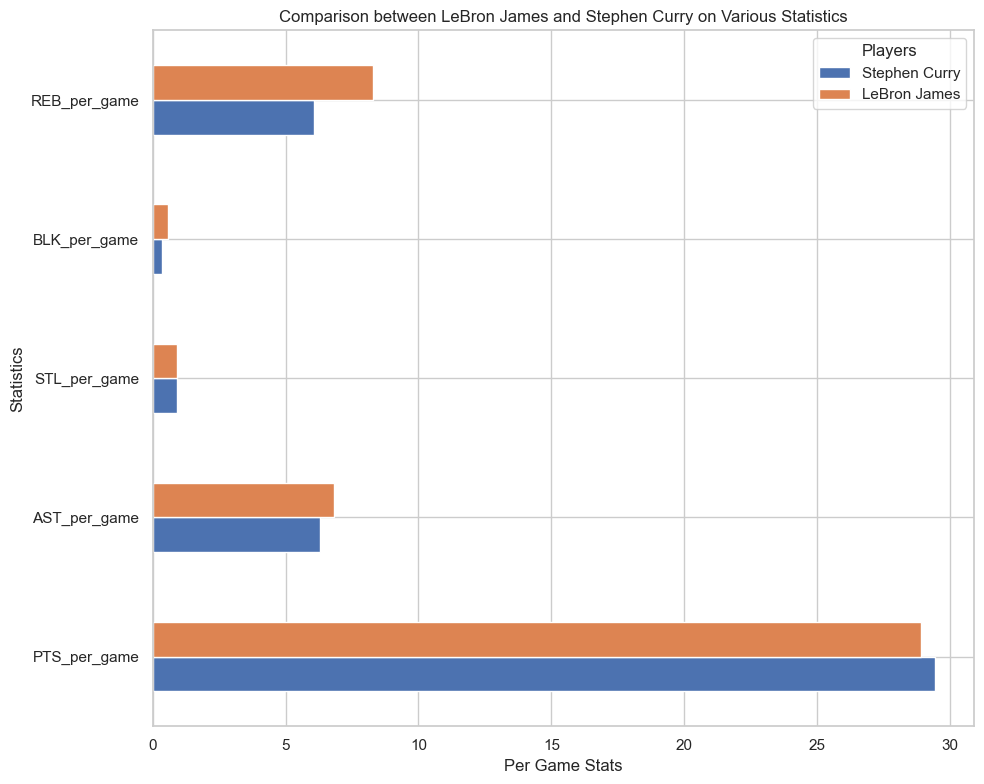

In [168]:
# Setting up the comparison data for bar chart
comparison_data = players_df_superstars.set_index('PLAYER_NAME')[['PTS_per_game', 'AST_per_game', 'STL_per_game', 'BLK_per_game', 'REB_per_game']]

# Plotting a horizontal bar chart for direct comparison of statistics
plt.figure(figsize=(10, 8))

# Transpose the dataframe to have statistics as rows
comparison_data_transposed = comparison_data.T

# Plotting
comparison_data_transposed.plot(kind='barh', ax=plt.gca())
plt.title('Comparison between LeBron James and Stephen Curry on Various Statistics')
plt.xlabel('Per Game Stats')
plt.ylabel('Statistics')
plt.legend(title='Players')
plt.tight_layout()
plt.show()

### Observations:
LeBron James and Stephen Curry are two of my favorite players. LeBron is playing at the Los Angeles Lakers as a small forward, and Curry is playing at the Golden State Warriors as a point guard.

From the plot we can see that Curry has a higher points per game. However, LeBron has a higher assists, blocks, and rebounds per game. 

# STEP 5 - Summary
## 1. What I learned from this project?
- How to use the Python libraries such as Pandas, Numpy, Matplotlib, Seaborn, etc. to do the data analysis.
- How to use the Python libraries such as Scikit-learn to do the machine learning, modeling some data to predict the win or loss of a team.
- How to use some APIs to get the data from the Internet. It is quit convenient to get the data from the Internet.

Throughout this project, I used 3 datasets about the NBA games in 2022-2023 season. I did some data cleaning, data preprocessing, data visualization, and machine learning. As a fan of NBA, I really enjoyed doing this project. I can use the data to analyze the performance of my favorite team and my favorite players. I can also use the data to predict the win or loss of a team(although the accuracy is not very high).

## 2. For future work
There should be a lot of data analysts who are professional in NBA. I am just a beginner. I think I can learn something more about the NBA data analysis from them. 

As I know that, there are some websites that provide the NBA data, and there are countless kinds of data. So there are some more things that I may do in the future, based on the similar datasets:

1. **Temporal Analysis**: Tracking the performance of players across different seasons or before and after major events (e.g., injuries, team changes) could yield insights into their development and adaptability.

2. **Advanced Metrics**: Incorporating advanced metrics such as Player Efficiency Rating (PER), Win Shares, Box Plus/Minus (BPM), and VORP could provide a more nuanced view of a player's impact on the game.

3. **Contextual Comparison**: Comparing players within the context of their team's performance, such as how a player's stats contribute to wins or how they perform under different coaching strategies.

4. **Clutch Performance**: Analyzing performance during critical periods of games (last 5 minutes with point differences of less than 10) to evaluate how players handle high-pressure situations.

5. **Player Tracking Data**: Utilizing player tracking data to analyze movement, speed, and spacing on the court, which could provide insights into defensive prowess and offensive efficiency that traditional stats might miss.

6. **Injury Impact**: Studying the impact of injuries on players' performance and their teams' overall success could be insightful, especially for managing player health and predicting future performance.

7. **Fan Engagement**: Exploring social media and fan engagement data could reveal the popularity and marketability of players, which is another aspect of their value to a team beyond on-court performance.